# Siamese Neural Network — Trade Matching Pipeline

This notebook implements an end-to-end **learning-to-rank** pipeline using a **Siamese neural network** to match financial trades across systems.

**Pipeline Steps:**
1. **Environment & Imports** — Detect runtime (Local / Databricks) and load project modules
2. **Configuration** — Define column mappings and candidate retrieval thresholds
3. **Data Loading & Cleaning** — Load trade data, filter to valid matched pairs
4. **Train / Val / Test Split** — Stratified group split to prevent data leakage
5. **Episode Construction** — Build training episodes with hard-negative mining
6. **TF-IDF Vectorisation** — Fit character n-gram vectorizer on training text
7. **Model Initialisation** — Create Siamese network, dataset wrappers, and data loaders
8. **Training Loop** — Train with listwise cross-entropy and early stopping
9. **Evaluation** — Test set performance and analysis visuals

Each section includes artifact inspection so you can verify intermediate outputs.

## Step 1 — Environment & Imports

Detect whether we're running locally or in Databricks, set up `sys.path` so Python can find our project modules, then import all pipeline components.

In [54]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Detect runtime environment ---
IN_DATABRICKS = "DATABRICKS_RUNTIME_VERSION" in os.environ

# --- Setup Paths ---
if IN_DATABRICKS:
    # In Databricks Repos the working dir is the repo root
    project_root = os.getcwd()
else:
    current_dir = os.getcwd()
    if current_dir.endswith("notebooks"):
        project_root = os.path.abspath(os.path.join(current_dir, "../../../.."))
    elif os.path.exists("src"):
        project_root = current_dir
    else:
        project_root = current_dir

if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project Root: {project_root}")
print(f"Environment:  {'Databricks' if IN_DATABRICKS else 'Local'}")

# --- Project Imports ---
from src.model.nn_matching.pipeline.data_prep import (
    normalize, normalize_and_combine, rebuild_combined_text_for_row,
    add_date_int_cols, stratified_group_split_3way,
)
from src.model.nn_matching.pipeline.candidate_generation import (
    get_candidates,
    build_training_episodes_single_df_debug,
    build_training_episodes_parallel,
    build_training_episodes_sequential,
    build_training_episodes_spark,
)
from src.model.nn_matching.pipeline.vectorization import (
    iter_episode_text, vectorize_episode
)
from src.model.nn_matching.pipeline.augmentation import (
    augment_query, token_dropout, token_swap, char_noise,
    synonym_substitution, field_omission, scalar_perturbation,
    DEFAULT_SYNONYMS,
)
from src.model.nn_matching.models.siamese_network import (
    SiameseMatchingNet, RankingEpisodeDataset, collate_episodes_flat
)
from src.model.nn_matching.models.losses import (
    listwise_ce_from_groups, batch_metrics_from_logits
)
from torch.utils.data import DataLoader

Project Root: /Users/adrianvargas/Documents/projects/siamese_neural_net
Environment:  Local


## Step 2 — Configuration

Define the column names that map to your dataset and the thresholds for candidate retrieval (blocking). These control how hard-negatives are selected during episode construction.

| Parameter | Purpose |
|-----------|---------|
| `WINDOW_DAYS` | Maximum date difference (days) between query and candidate |
| `AMOUNT_TOL_PCT` | Maximum relative amount difference (30% = 0.30) |
| `TOP_K` | Max candidates returned per query |
| `TRAIN_K_NEG` | Negatives per training episode |

In [55]:
# Column names and matching parameters — adjust these per dataset
ID_COL = "Trade Id"
REF_COL = None
DATE_COLS = ["Trade Date", "Trade Maturity Date", "Trade Value Date"]
DATE_INT_COLS = [f"{c}_int" for c in DATE_COLS]
EPOCH = pd.Timestamp("1970-01-01")

AMOUNT_COL = "GBP_Absolute"
CURRENCY_COL = "Transactional Currency"

# Candidate retrieval thresholds
WINDOW_DAYS = 20
AMOUNT_TOL_PCT = 0.30
TOP_K = 50
TRAIN_K_NEG = 10
ENFORCE_SAME_SIGN = False
DATE_POLICY = "any"

# Manual Episode Counts (set to None to use dynamic sizing based on data size)
# If set to an integer (e.g. 1000), it will override the dynamic calculation
N_EPISODES_TRAIN = 1000
N_EPISODES_VAL   = None
N_EPISODES_TEST  = None

# ── Data Augmentation (all optional) ─────────────────────────────
# Master switch: set to True to enable augmentation on TRAINING data only.
# Val/Test are NEVER augmented — they must reflect clean, real-world data.
AUGMENT_TRAIN = True

# Each perturbation type is independently toggleable.
# Set any enable_* flag to False to disable that specific perturbation.
AUGMENT_PARAMS = {
    # ── Text perturbations ──
    "enable_token_dropout":  True,     # Remove random words (simulates missing fields)
    "enable_token_swap":     False,    # Swap adjacent words (simulates reordering)
    "enable_char_noise":     True,     # Typos: insert/delete/substitute chars
    "enable_synonym_sub":    False,    # Replace with abbreviations (e.g. "Limited" → "Ltd")
    "enable_field_omission": True,     # Blank entire text column + rebuild combined_text
    # ── Scalar perturbations ──
    "enable_scalar_noise":   True,     # Amount jitter + date shifts
    # ── Fine-tuning knobs (safe defaults) ──
    "token_drop_prob":   0.15,         # Prob of dropping each token (0.10–0.20)
    "token_swap_prob":   0.10,         # Prob of performing a swap (0.10–0.15)
    "char_noise_prob":   0.05,         # Prob of char noise per token (0.03–0.08)
    "synonym_sub_prob":  0.20,         # Prob of substituting each eligible token (0.15–0.30)
    "field_drop_prob":   0.10,         # Prob of blanking a field (0.05–0.15)
    "amount_jitter_std": 0.005,        # Relative std for amount noise, 0.5% (0.002–0.01)
    "date_shift_max":    2,            # Max ±days to shift (1–3)
    "date_shift_prob":   0.30,         # Prob of shifting each date column (0.2–0.4)
}

timing_stats = defaultdict(float)

## Step 3 — Data Loading & Cleaning

Load the trade dataset, filter to valid matched pairs (1-to-1 only), and prepare for splitting. The filtering pipeline:

**Raw data → matched trades only → allowed match rules → valid Match IDs → group size = 2 (1-to-1 pairs)**

This ensures we only train on clean, unambiguous match pairs where each trade has exactly one counterpart.

In [56]:
# Load private config (column lists, filtering rules). Falls back to empty if missing.
try:
    from private_config import COMMENTS, MATCH_RULE, MATCH_ID, example_data, COLUMNS_TO_SELECT
except ImportError:
    print("Warning: private_config.py not found. Please ensure the file is present.")
    COMMENTS = []
    MATCH_RULE = []
    MATCH_ID = []
    example_data = []
    COLUMNS_TO_SELECT = []

In [57]:
# Import synthetic data generator (private, gitignored)
try:
    from private_data_generation import generate_synthetic_data
except ImportError:
    print("Warning: private_data_generation.py not found.")
    def generate_synthetic_data(*args, **kwargs):
        raise NotImplementedError("Synthetic data generation code is missing.")

In [58]:
# Generate synthetic data and sanity-check a few matched pairs
df_synth = generate_synthetic_data(n_rows=5000, overwrite=True)
print(f"Generated shape: {df_synth.shape}")

matched_subset = df_synth[df_synth["matched"]].sort_values("Match ID").head(4)
display(matched_subset[["Trade Id", "Match ID", "Comments", "Match Rule", "Transactional Currency", "GBP Currency Amount", "Trade Date"]])

Generated shape: (5000, 48)


,Trade Id,Match ID,Comments,Match Rule,Transactional Currency,GBP Currency Amount,Trade Date
4271,T000004272,17911-7794_1000,FlexRep SAP,Adb Adjustment Text,EUR,-920163.958589,2025-02-13
862,T000000863,17911-7794_1000,FlexRep SAP,Adb Adjustment Text,EUR,920163.958589,2025-02-13
2033,T000002034,17911-7794_102,Offsetting Journals,Unique Instrument Identifier,GBP,860911.689167,2025-09-05
4468,T000004469,17911-7794_102,Offsetting Journals,Unique Instrument Identifier,GBP,-860911.689167,2025-09-05


In [59]:
# Load data — tries parquet first, falls back to CSV, then generates if needed
DATA_FILENAME = "synthetic_derivatives_data.parquet"

if IN_DATABRICKS:
    # In Databricks Repos the file lives at /Workspace/Repos/<user>/<repo>/
    DATA_PATH = os.path.join(project_root, DATA_FILENAME)
else:
    DATA_PATH = os.path.join(project_root, DATA_FILENAME)

if os.path.exists(DATA_PATH):
    try:
        df = pd.read_parquet(DATA_PATH)
    except:
        df = pd.read_csv(DATA_PATH.replace(".parquet", ".csv"))
else:
    csv_path = DATA_PATH.replace(".parquet", ".csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    elif os.path.exists(DATA_FILENAME.replace(".parquet", ".csv")):
        df = pd.read_csv(DATA_FILENAME.replace(".parquet", ".csv"))
    else:
        print(f"Data not found at {DATA_PATH}, generating new...")
        df = generate_synthetic_data(1000)

display(df.head(200))

,Business Date,TETB FISS Number,Acct Ico Match Level 3 Name,FLEX Balance Source,Master Book Code,Username,Racc MU,Reporting Party MCU Code,Sap Cost Centre,Sap Acct Description,...,Reporting Party SU,PDC SU,Relationship,GBP Currency Amount,GBP_Absolute,matched,Match Type,Comments,Match Rule,Match ID
0,2025-02-02,212814952.0,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,1.481480e+06,1.481480e+06,True,Matched with differences,Matched by Derived Trade Id,Adb Adjustment Text,ldn057de2ff_470
1,2025-10-10,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,6.376945e+05,6.376945e+05,False,Exact Match,Unmatched,Unmatched,NaN
2,2025-08-27,212814952.0,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,5.731204e+05,5.731204e+05,False,Matched with differences,Unmatched,Unmatched,NaN
3,2025-11-29,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,-8.469405e+05,8.469405e+05,True,Exact Match,Matched by Derivative Netting,B-B1,Zero Value_570
4,2025-06-08,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,1.494277e+06,1.494277e+06,True,Exact Match,Matched by Derivative Netting,Sub Ledger Account + Absolute of Transactional...,ldn057f4f4b_498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2025-02-01,NaN,I/C BSd Derivatives,GBS,838583,No Data,M635,43423,25940-7750,Intl Cr-B Book Deriv,...,NaN,NaN,NaN,2.164115e+05,2.164115e+05,True,Exact Match,OTC Payment Control Account,Trade Maturity Date + |abs(Leg1)| + abs(Leg2)|...,2013-01-25_2014-09-17_EUR_112
196,2025-07-10,NaN,I/C BSd Derivatives,GBS,838583,No Data,M635,43423,25940-7750,Intl Cr-B Book Deriv,...,NaN,NaN,NaN,-1.159547e+06,1.159547e+06,True,Exact Match,FlexRep SAP,Offsetting Trade Id,ESHLA BUK late fee posting 24660833B (Charms I...
197,2025-02-13,NaN,I/C BSd Derivatives,GBS,838583,No Data,M635,43423,25940-7750,Intl Cr-B Book Deriv,...,NaN,NaN,NaN,1.200921e+05,1.200921e+05,False,Exact Match,Unmatched,Unmatched,NaN
198,2025-05-04,212814952.0,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,1.375898e+06,1.375898e+06,False,Matched with differences,Unmatched,Unmatched,NaN


In [60]:
# Keep only the columns needed for matching
df_clean = df[COLUMNS_TO_SELECT]
df_clean.head(5)

,Business Date,TETB FISS Number,Acct Ico Match Level 3 Name,FLEX Balance Source,Master Book Code,Username,Racc MU,Reporting Party MCU Code,Sap Cost Centre,Sap Acct Description,...,Reporting Party SU,PDC SU,Relationship,GBP Currency Amount,GBP_Absolute,matched,Match Type,Comments,Match Rule,Match ID
0,2025-02-02,212814952.0,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,1.481480e+06,1.481480e+06,True,Matched with differences,Matched by Derived Trade Id,Adb Adjustment Text,ldn057de2ff_470
1,2025-10-10,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,6.376945e+05,6.376945e+05,False,Exact Match,Unmatched,Unmatched,NaN
2,2025-08-27,212814952.0,I/C BSd Derivatives,MOTIF,517217,No Data,M620,20853,13878-3819,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,5.731204e+05,5.731204e+05,False,Matched with differences,Unmatched,Unmatched,NaN
3,2025-11-29,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,-8.469405e+05,8.469405e+05,True,Exact Match,Matched by Derivative Netting,B-B1,Zero Value_570
4,2025-06-08,NaN,I/C BSd Derivatives,GBS,827469,Sri Varun Satuluri,M635,41981,48238-7750,Intl Dr-B Book Deriv,...,NaN,NaN,NaN,1.494277e+06,1.494277e+06,True,Exact Match,Matched by Derivative Netting,Sub Ledger Account + Absolute of Transactional...,ldn057f4f4b_498


In [61]:
# Filter to matched trades with valid Match IDs, then keep only 1-to-1 pairs (group size == 2)
df_matched   = df_clean[df_clean["matched"] == True].copy().reset_index(drop=True)
df_unmatched = df_clean[df_clean["matched"] == False].copy().reset_index(drop=True)

print(f"Matched pool           : {len(df_matched):,} rows")
print(f"Unmatched (holdout): {len(df_unmatched):,} rows")

# 1) Filter by allowed match types and valid Match IDs
allowed = {
    "FX Revaluation",
    "Matched by Derived Trade Id",
    "Matched by Instrument Identifier and Trade Economics",
}

n0 = len(df_matched)

mask_comments  = df_matched["Comments"].isin(allowed)
mask_notna     = df_matched["Match ID"].notna()
mask_not_blank = df_matched["Match ID"].astype(str).str.strip() != ""
mask_not_ref   = df_matched["Match ID"].astype(str) != "#REF!"

mask_valid_id = mask_notna & mask_not_blank & mask_not_ref

drop_not_allowed = (~mask_comments).sum()
drop_bad_match_id = (mask_comments & ~mask_valid_id).sum()

df_m_rules = df_matched.loc[mask_comments].copy()
df_m_valid = df_matched.loc[mask_comments & mask_valid_id].copy()

n_rules = len(df_m_rules)
n_valid = len(df_m_valid)

print("\n=== Matched stream | rule & Match ID filtering ===")
print(f"Rows before filtering (matched) : {n0:,}")
print(f"- dropped (Comments not allowed): {drop_not_allowed:,}")
print(f"- remaining after Comments filter: {n_rules:,}")
print(f"- dropped (invalid Match ID): {drop_bad_match_id:,}")
print(f"Rows after Comments+ID filters: {n_valid:,}")

# 2) Keep only 1-to-1 matches (exactly 2 rows per Match ID)
vc = df_m_valid["Match ID"].value_counts()

ids_size_1 = vc[vc == 1].index
ids_size_2 = vc[vc == 2].index
ids_size_3 = vc[vc == 3].index
ids_size_4 = vc[vc == 4].index
ids_size_5p = vc[vc >= 5].index

df_matched_1to1 = df_m_valid[df_m_valid["Match ID"].isin(ids_size_2)].copy()

n_rows_kept = len(df_matched_1to1)
n_ids_total = vc.shape[0]

print("\n=== 1-to-1 selection (group size == 2) ===")
print(f"Unique Match IDs after filters: {n_ids_total:,}")
print(f"- IDs with size=1: {len(ids_size_1):,}")
print(f"- IDs with size=2 (KEPT): {len(ids_size_2):,}")
print(f"- IDs with size=3: {len(ids_size_3):,}")
print(f"- IDs with size=4: {len(ids_size_4):,}")
print(f"- IDs with size>=5: {len(ids_size_5p):,}")
print(f"Rows KEPT in 1-to-1 set: {n_rows_kept:,} (should be 2 * #IDs kept)")

freq_of_freq = vc.value_counts().sort_index()
print("\nFull size distribution (cluster size -> number of Match IDs):")
print(freq_of_freq)

# 3) Per-rule summary
by_rule_before = (
    df_m_valid.groupby("Comments")["Match ID"]
    .nunique()
    .rename("Unique Match IDs (after Comments+ID filters)")
    .sort_values(ascending=False)
)

by_rule_after = (
    df_matched_1to1.groupby("Comments")["Match ID"]
    .nunique()
    .rename("Unique Match IDs kept (size=2)")
    .sort_values(ascending=False)
)

print("\n=== Per-Comments unique Match IDs (before vs kept) ===")
per_rule = pd.concat([by_rule_before, by_rule_after], axis=1).fillna(0).astype(int)
print(per_rule)

rows_by_rule_before = (
    df_m_valid["Comments"].value_counts().rename("Rows after Comments+ID filters")
)
rows_by_rule_after = (
    df_matched_1to1["Comments"].value_counts().rename("Rows kept (1-to-1)")
)

print("\n=== Per-Comments row counts (before vs kept) ===")
rows_rule = pd.concat([rows_by_rule_before, rows_by_rule_after], axis=1).fillna(0).astype(int)
print(rows_rule)

# 4) Final artefacts
print("\n=== Final artifacts ===")
print(f"Unmatched (holdout) rows: {len(df_unmatched):,}")
print(
    f"Matched 1-to-1 rows     : {len(df_matched_1to1):,} "
    f"(unique Match IDs: {df_matched_1to1['Match ID'].nunique():,})"
)

Matched pool           : 608 rows
Unmatched (holdout): 392 rows

=== Matched stream | rule & Match ID filtering ===
Rows before filtering (matched) : 608
- dropped (Comments not allowed): 448
- remaining after Comments filter: 160
- dropped (invalid Match ID): 0
Rows after Comments+ID filters: 160

=== 1-to-1 selection (group size == 2) ===
Unique Match IDs after filters: 80
- IDs with size=1: 0
- IDs with size=2 (KEPT): 80
- IDs with size=3: 0
- IDs with size=4: 0
- IDs with size>=5: 0
Rows KEPT in 1-to-1 set: 160 (should be 2 * #IDs kept)

Full size distribution (cluster size -> number of Match IDs):
count
2    80
Name: count, dtype: int64

=== Per-Comments unique Match IDs (before vs kept) ===
                                                    Unique Match IDs (after Comments+ID filters)  \
Comments                                                                                           
Matched by Derived Trade Id                                                                   

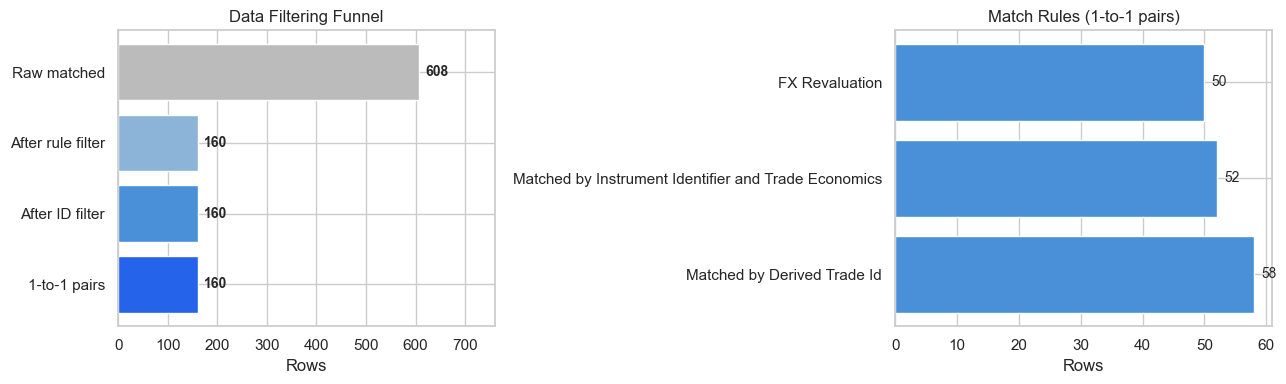

In [62]:
# Visual: Data filtering funnel and match-rule distribution
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: Filtering funnel
stages = ["Raw matched", "After rule filter", "After ID filter", "1-to-1 pairs"]
counts = [n0, n_rules, n_valid, n_rows_kept]
colors = ["#bbb", "#8cb4d9", "#4a90d9", "#2563eb"]
bars = axes[0].barh(stages[::-1], counts[::-1], color=colors[::-1], edgecolor="white")
for bar, c in zip(bars, counts[::-1]):
    axes[0].text(bar.get_width() + max(counts)*0.02, bar.get_y() + bar.get_height()/2,
                 f"{c:,}", va="center", fontsize=10, fontweight="bold")
axes[0].set_xlabel("Rows")
axes[0].set_title("Data Filtering Funnel")
axes[0].set_xlim(0, max(counts) * 1.25)

# Right: Match rule distribution (final 1-to-1 set)
rule_counts = df_matched_1to1["Comments"].value_counts()
axes[1].barh(rule_counts.index, rule_counts.values, color="#4a90d9", edgecolor="white")
for i, (v, name) in enumerate(zip(rule_counts.values, rule_counts.index)):
    axes[1].text(v + max(rule_counts.values)*0.02, i, f"{v:,}", va="center", fontsize=10)
axes[1].set_xlabel("Rows")
axes[1].set_title("Match Rules (1-to-1 pairs)")

plt.tight_layout()
plt.show()

## Step 4 — Train / Val / Test Split

Split by **Match ID groups** (not individual rows) to prevent data leakage — if two rows share a Match ID, both go into the same split. Uses stratification by match rule to ensure each split has a representative rule distribution.

| Split | Purpose | Typical size |
|-------|---------|--------------|
| **Train** (70%) | Fit model weights | Largest portion |
| **Val** (15%) | Early stopping & hyperparameter tuning | Monitor during training |
| **Test** (15%) | Final held-out evaluation | Never seen during training |

In [35]:
# Text columns concatenated into combined_text for TF-IDF input
columns_to_normalize_reduced = [
    "Trade Id",
    "Alternate Trade Id", "Alternate Trade Id 2", "Deal ID",
    "Unique Instrument Identifier", "TETB FISS Number",
    "Instrument Name", "ISIN", "CUSIP", "SEDOL",
]

In [36]:
# Split into train/val/test by Match ID groups (no leakage across splits)
if 'df_synth' in globals():
    df_clean = df_synth[df_synth["matched"]].copy()

    try:
        df_train, df_val, df_test = stratified_group_split_3way(
            df_clean, 
            group_col="Match ID", 
            strat_col="Comments",
            train_size=0.7, 
            val_size=0.15, 
            test_size=0.15, 
            random_state=42
        )
    except ValueError as e:
        print(f"Stratified split failed (small sample): {e}")
        print("Falling back to random group split.")
        
        groups = df_clean["Match ID"].unique()
        rng = np.random.default_rng(42)
        rng.shuffle(groups)
        
        n = len(groups)
        n_train = int(n * 0.7)
        n_val = int(n * 0.15)
        
        train_groups = set(groups[:n_train])
        val_groups = set(groups[n_train:n_train+n_val])
        test_groups = set(groups[n_train+n_val:])
        
        df_train = df_clean[df_clean["Match ID"].isin(train_groups)].copy()
        df_val = df_clean[df_clean["Match ID"].isin(val_groups)].copy()
        df_test = df_clean[df_clean["Match ID"].isin(test_groups)].copy()

    # Build combined_text before episode construction (required for TF-IDF)
    print("Creating combined_text column for train/val/test splits...")
    df_train = normalize_and_combine(df_train, columns_to_normalize_reduced)
    df_val = normalize_and_combine(df_val, columns_to_normalize_reduced)
    df_test = normalize_and_combine(df_test, columns_to_normalize_reduced)

    print(f"Splits created: Train={len(df_train)}, Val={len(df_val)}, Test={len(df_test)}")
else:
    print("Warning: df_synth not found. Run the data generation cell first.")

Creating combined_text column for train/val/test splits...
Splits created: Train=2056, Val=440, Test=442


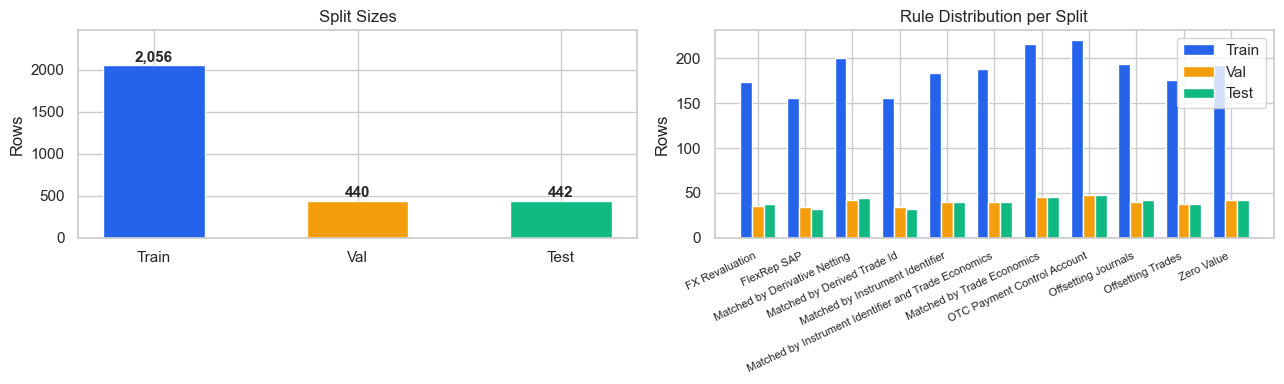

In [37]:
# Visual: Split sizes and rule distribution across splits
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: Split sizes
split_names = ["Train", "Val", "Test"]
split_sizes = [len(df_train), len(df_val), len(df_test)]
colors = ["#2563eb", "#f59e0b", "#10b981"]
bars = axes[0].bar(split_names, split_sizes, color=colors, edgecolor="white", width=0.5)
for bar, s in zip(bars, split_sizes):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(split_sizes)*0.02,
                 f"{s:,}", ha="center", fontsize=11, fontweight="bold")
axes[0].set_ylabel("Rows")
axes[0].set_title("Split Sizes")
axes[0].set_ylim(0, max(split_sizes) * 1.2)

# Right: Rule distribution per split (stacked)
all_rules = sorted(set(df_train["Comments"].unique()) |
                   set(df_val["Comments"].unique()) |
                   set(df_test["Comments"].unique()))
x = np.arange(len(all_rules))
w = 0.25
for i, (name, df_split, color) in enumerate(zip(split_names, [df_train, df_val, df_test], colors)):
    counts = [len(df_split[df_split["Comments"] == r]) for r in all_rules]
    axes[1].bar(x + i*w, counts, w, label=name, color=color, edgecolor="white")

axes[1].set_xticks(x + w)
axes[1].set_xticklabels(all_rules, rotation=25, ha="right", fontsize=8)
axes[1].set_ylabel("Rows")
axes[1].set_title("Rule Distribution per Split")
axes[1].legend()

plt.tight_layout()
plt.show()

## Step 5 — Episode Construction

Each **episode** represents one learning-to-rank problem:
1. Pick a matched trade **B** (the positive answer)
2. Clone B into a **query A** with a synthetic Trade Id (prevents trivial matching)
3. Use **blocking** (currency → date window → amount tolerance) to retrieve hard-negative candidates
4. Assemble: `[positive B, negative₁, negative₂, …, negativeₖ]`

The model must learn to rank the positive above all negatives using shared identifiers and economics — not memorised Trade IDs.

> **Hard negatives** are candidates that pass the blocking filters (same currency, similar date and amount) but are NOT the correct match. They force the model to learn fine-grained distinctions.

In [ ]:
# Add integer date columns needed by the candidate retrieval logic
df_pool_train = add_date_int_cols(df_train, DATE_COLS)
df_pool_val   = add_date_int_cols(df_val, DATE_COLS)
df_pool_test  = add_date_int_cols(df_test, DATE_COLS)

# ── Episode Sizing ──────────────────────────────────────────
# Check if manually defined in config, otherwise use ALL available trades (len(df_pool)).
# Each trade becomes a query once → maximum data coverage.
if 'N_EPISODES_TRAIN' not in globals() or N_EPISODES_TRAIN is None:
    N_EPISODES_TRAIN = len(df_pool_train)

if 'N_EPISODES_VAL' not in globals() or N_EPISODES_VAL is None:
    N_EPISODES_VAL = len(df_pool_val)

if 'N_EPISODES_TEST' not in globals() or N_EPISODES_TEST is None:
    N_EPISODES_TEST = len(df_pool_test)

print(f"📊 Episode Sizing:")
print(f"  Train pool: {len(df_pool_train):,} rows → {N_EPISODES_TRAIN:,} episodes")
print(f"  Val   pool: {len(df_pool_val):,} rows → {N_EPISODES_VAL:,} episodes")
print(f"  Test  pool: {len(df_pool_test):,} rows → {N_EPISODES_TEST:,} episodes")

# Shared config for the episode builder
_episode_kwargs = dict(
    id_col=ID_COL,
    currency_col=CURRENCY_COL,
    amount_col=AMOUNT_COL,
    date_int_cols=DATE_INT_COLS,
    columns_to_normalize=columns_to_normalize_reduced,
    ref_col=REF_COL,
    train_k_neg=20,
    rule_col="Match Rule",
    enforce_same_sign=True,
    window_days=WINDOW_DAYS,
    amount_tol_pct=AMOUNT_TOL_PCT,
    date_policy=DATE_POLICY,
)

# Pick the right builder for the current environment
if IN_DATABRICKS:
    _builder = build_training_episodes_spark
else:
    _builder = build_training_episodes_parallel

print(f"\nUsing builder: {_builder.__name__}")

# Val/Test episodes are pre-built (static) — they don't change between epochs
episodes_val, candidates_val_long_df = _builder(
    df_pool=df_pool_val, n_episodes=N_EPISODES_VAL, random_state=4242, **_episode_kwargs,
)
episodes_test, candidates_test_long_df = _builder(
    df_pool=df_pool_test, n_episodes=N_EPISODES_TEST, random_state=424242, **_episode_kwargs,
)

# Train episodes will be rebuilt dynamically each epoch (see training loop below)
# Build an initial set for TF-IDF fitting and inspection
episodes_train, candidates_train_long_df = _builder(
    df_pool=df_pool_train, n_episodes=N_EPISODES_TRAIN, random_state=42, **_episode_kwargs,
)

print(f"\n✅ Initial episodes built:")
print(f"  Train: {len(episodes_train):,}  |  Val: {len(episodes_val):,}  |  Test: {len(episodes_test):,}")

📊 Dynamic Episode Sizing:
  Train pool: 2,056 rows → 2,056 episodes
  Val   pool: 440 rows → 440 episodes
  Test  pool: 442 rows → 442 episodes

Using builder: build_training_episodes_parallel
Building 440 episodes with 7 workers …
✅ Done: 440 episodes, 0 errors, 13.4s
Building 442 episodes with 7 workers …
✅ Done: 440 episodes, 0 errors, 13.4s
Building 442 episodes with 7 workers …
✅ Done: 442 episodes, 0 errors, 19.9s
Building 2056 episodes with 7 workers …
✅ Done: 442 episodes, 0 errors, 19.9s
Building 2056 episodes with 7 workers …
✅ Done: 2056 episodes, 0 errors, 87.5s

✅ Initial episodes built:
  Train: 2,056  |  Val: 440  |  Test: 442
✅ Done: 2056 episodes, 0 errors, 87.5s

✅ Initial episodes built:
  Train: 2,056  |  Val: 440  |  Test: 442


📊 EPISODE INSPECTION (Example: Episode 0)
────────────────────────────────────────
  • Query ID:       Q::T000004365::298b7b7fa15648398cfee0feb866dbd1
  • Match Rule:     Zero Balance
  • Positive Index: 0 (Always 0)
  • Total Items:    21 (1 Positive + 20 Negatives)
  • Candidate IDs:  ['T000004365', 'T000002199', 'T000000712'] ...


/var/folders/lm/mg395mvd36g3fsqg6gjxv4r40000gn/T/ipykernel_80829/1335384999.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rule_counts.values, y=rule_counts.index, palette="viridis", ax=axes[1], orient='h')


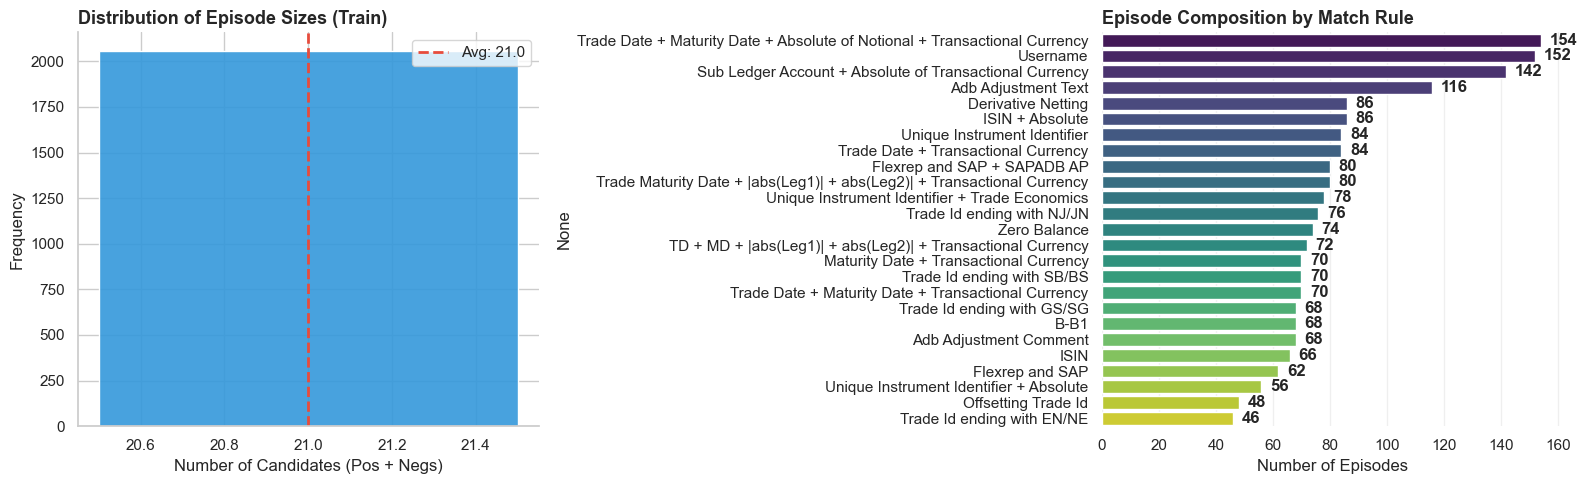


💡 INTERPRETATION:
• Left Chart: Shows how many candidates (hard negatives + 1 positive) are in each training episode.
  - If consistent (e.g., spike at 21), it means the blocker successfully found the requested 'k' negatives.
  - If skewed left, the blocker struggled to find enough hard negatives (easy queries).
• Right Chart: Shows the diversity of match logic. A balanced dataset helps the model learn generalized matching.


In [39]:
# Inspect: Episode structure and candidate distribution
import seaborn as sns
sns.set_theme(style="whitegrid", context="notebook")

if episodes_train:
    # 1. Show structure of a single episode
    ep = episodes_train[0]
    print(f"📊 EPISODE INSPECTION (Example: Episode 0)")
    print(f"{'─'*40}")
    print(f"  • Query ID:       {ep['query_id']}")
    print(f"  • Match Rule:     {ep['rule']}")
    print(f"  • Positive Index: {ep['positive_index']} (Always 0)")
    print(f"  • Total Items:    {len(ep['candidates_df'])} (1 Positive + {len(ep['candidates_df'])-1} Negatives)")
    print(f"  • Candidate IDs:  {ep['candidate_ids'][:3]} ...")
    
    # 2. Visualise Distributions
    cand_counts = [len(e["candidates_df"]) for e in episodes_train]
    rule_counts = pd.Series([e["rule"] for e in episodes_train]).value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    palette = sns.color_palette("mako")
    
    # Left: Histogram of Candidates per Episode
    sns.histplot(cand_counts, bins=np.arange(min(cand_counts), max(cand_counts)+2)-0.5, 
                 kde=False, color="#3498db", ax=axes[0], edgecolor="white", alpha=0.9)
    axes[0].axvline(np.mean(cand_counts), color="#e74c3c", ls="--", lw=2, 
                    label=f"Avg: {np.mean(cand_counts):.1f}")
    
    axes[0].set_title("Distribution of Episode Sizes (Train)", fontsize=13, fontweight='bold', loc='left')
    axes[0].set_xlabel("Number of Candidates (Pos + Negs)")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    sns.despine(ax=axes[0])
    
    # Right: Episodes per Match Rule
    sns.barplot(x=rule_counts.values, y=rule_counts.index, palette="viridis", ax=axes[1], orient='h')
    
    # Add count labels
    for i, v in enumerate(rule_counts.values):
        axes[1].text(v + (max(rule_counts.values)*0.02), i, f"{v}", va='center', fontweight='bold')
        
    axes[1].set_title("Episode Composition by Match Rule", fontsize=13, fontweight='bold', loc='left')
    axes[1].set_xlabel("Number of Episodes")
    axes[1].grid(axis='x', alpha=0.3)
    sns.despine(ax=axes[1], left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    print("• Left Chart: Shows how many candidates (hard negatives + 1 positive) are in each training episode.")
    print("  - If consistent (e.g., spike at 21), it means the blocker successfully found the requested 'k' negatives.")
    print("  - If skewed left, the blocker struggled to find enough hard negatives (easy queries).")
    print(f"• Right Chart: Shows the diversity of match logic. A balanced dataset helps the model learn generalized matching.")

## Step 5b — Data Augmentation Deep Dive

**Goal:** Make the model robust to real-world data noise by perturbing the **query side only** during training.

### Why Augment?
Without augmentation, the model memorises exact text/amount/date patterns. In production, trades arrive with typos, missing fields, rounding differences, and different naming conventions. Augmentation teaches the model: *"even if the query looks slightly different, it's still the same trade."*

### Architecture: Option B (recommended)
Noise is applied inside `RankingEpisodeDataset.__getitem__()` — so every call to the dataset produces a **different** perturbation of the same episode. Combined with dynamic episode rebuilding (new negatives each epoch), the model effectively never sees the same training example twice.

### Available Perturbations

| # | Function | What it simulates | Default |
|---|----------|-------------------|---------|
| 1 | `token_dropout` | Missing fields / partial data | ON |
| 2 | `token_swap` | Reordered fields | OFF |
| 3 | `char_noise` | Typos / OCR errors | ON |
| 4 | `synonym_substitution` | "International" → "Intl" | OFF |
| 5 | `field_omission` | Entire column missing | ON |
| 6 | `scalar_perturbation` | Rounding / T+1 date shifts | ON |

Each perturbation is **independently toggleable** via the `AUGMENT_PARAMS` dict in Step 2.

### Critical Rules
- **Query only** — candidates are never corrupted
- **Pair features** (`log_amt_diff`, `log_date_diff`) are derived from the noisy scalars automatically — never injected directly
- **Val/Test** are never augmented — they must reflect clean data

AUGMENTATION DEMO — What happens to a real query row

📋 ORIGINAL QUERY:
   combined_text : 'q t000004365 298b7b7fa15648398cfee0feb866dbd1 2060762 s0492e4b 95r81y4 212814952 95r81y4'
   GBP_Absolute: 1468296.8994277194
   Trade Date_int: 20300.0
   Trade Maturity Date_int: 20431.0
   Trade Value Date_int: 20311.0

──────────────────────────────────────────────────────────────────────
🔧 1. Token Dropout
   Text: 'q t000004365 298b7b7fa15648398cfee0feb866dbd1 2060762 95r81y4 212814952 95r81y4'
   ❌ Removed tokens: {'s0492e4b'}
   Amount: (unchanged)

──────────────────────────────────────────────────────────────────────
🔧 2. Token Swap
   Text: 'q t000004365 298b7b7fa15648398cfee0feb866dbd1 2060762 95r81y4 s0492e4b 212814952 95r81y4'
   🔄 Token order changed (same tokens, different order)
   Amount: (unchanged)

──────────────────────────────────────────────────────────────────────
🔧 3. Char Noise
   Text: 'q t000004365 298b7b7fa15648398cfee0feb866dbd1 2060762 s0492e4 95r81y4 212814952 95

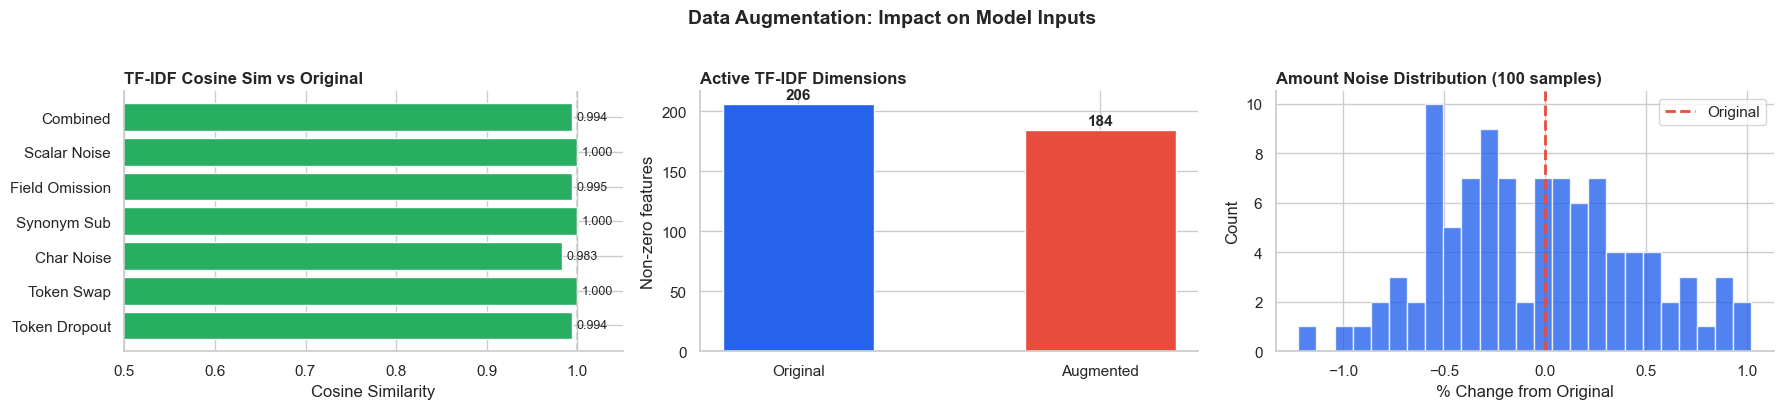


💡 HOW TO READ THIS:
• TF-IDF Cosine Similarity: How 'close' the augmented text is to the original in TF-IDF space.
  Green (>0.95) = very mild noise.  Yellow (0.85-0.95) = moderate.  Red (<0.85) = aggressive.
  Goal: Keep similarity high enough that the model CAN still match, but low enough to add diversity.
• Active TF-IDF Dimensions: Token dropout/field omission REDUCES non-zero dimensions.
  Char noise may CHANGE some but keeps roughly the same count.
• Amount Noise: Shows the distribution of percentage changes across 100 random augmentations.
  With std=0.005, most changes are within ±1% — realistic for rounding/FX differences.


In [63]:
# ── 5b. Augmentation Demo: Before vs After on a real episode ──────
# Shows exactly what each perturbation does to a real query row.
import seaborn as sns

demo_ep = episodes_train[0]
original_row = demo_ep["query_row"].copy()
rng_demo = np.random.default_rng(42)

print("=" * 80)
print("AUGMENTATION DEMO — What happens to a real query row")
print("=" * 80)

# ─── Show original ────────────────────────────────────────────────
orig_text = str(original_row.get("combined_text", ""))
orig_amount = original_row.get(AMOUNT_COL, 0.0)
orig_dates = {c: original_row.get(f"{c}_int", None) for c in DATE_COLS}

print(f"\n📋 ORIGINAL QUERY:")
print(f"   combined_text : '{orig_text[:100]}{'...' if len(orig_text) > 100 else ''}'")
print(f"   {AMOUNT_COL}: {orig_amount}")
for c, v in orig_dates.items():
    print(f"   {c}_int: {v}")

# ─── Apply each perturbation individually ─────────────────────────
perturbations = {
    "1. Token Dropout": {"enable_token_dropout": True, "token_drop_prob": 0.25},
    "2. Token Swap": {"enable_token_swap": True, "token_swap_prob": 1.0},
    "3. Char Noise": {"enable_char_noise": True, "char_noise_prob": 0.15},
    "4. Synonym Sub": {"enable_synonym_sub": True, "synonym_sub_prob": 1.0},
    "5. Field Omission": {"enable_field_omission": True, "field_drop_prob": 1.0},
    "6. Scalar Noise": {"enable_scalar_noise": True, "amount_jitter_std": 0.01, "date_shift_prob": 1.0, "date_shift_max": 2},
}

results = {}
for name, params in perturbations.items():
    rng_demo = np.random.default_rng(42)  # Same seed for reproducibility
    aug_row = augment_query(
        original_row,
        columns_to_normalize=columns_to_normalize_reduced,
        amount_col=AMOUNT_COL,
        date_int_cols=DATE_INT_COLS,
        rng=rng_demo,
        **params,
    )
    aug_text = str(aug_row.get("combined_text", ""))
    aug_amount = aug_row.get(AMOUNT_COL, 0.0)
    aug_dates = {c: aug_row.get(f"{c}_int", None) for c in DATE_COLS}
    results[name] = {"text": aug_text, "amount": aug_amount, "dates": aug_dates, "row": aug_row}
    
    print(f"\n{'─' * 70}")
    print(f"🔧 {name}")
    
    # Highlight text changes
    if aug_text != orig_text:
        # Show token-level diff
        orig_tokens = set(orig_text.split())
        aug_tokens = set(aug_text.split())
        removed = orig_tokens - aug_tokens
        added = aug_tokens - orig_tokens
        print(f"   Text: '{aug_text[:100]}{'...' if len(aug_text) > 100 else ''}'")
        if removed:
            print(f"   ❌ Removed tokens: {removed}")
        if added:
            print(f"   ✅ Added tokens: {added}")
        if not removed and not added:
            print(f"   🔄 Token order changed (same tokens, different order)")
    else:
        print(f"   Text: (unchanged)")
    
    # Highlight scalar changes
    if abs(float(aug_amount) - float(orig_amount)) > 1e-6:
        pct = abs(float(aug_amount) - float(orig_amount)) / max(abs(float(orig_amount)), 1e-12) * 100
        print(f"   Amount: {float(orig_amount):.2f} → {float(aug_amount):.2f} ({pct:.3f}% change)")
    else:
        print(f"   Amount: (unchanged)")
    
    for c in DATE_COLS:
        ov = orig_dates[c]
        av = aug_dates[c]
        if ov is not None and av is not None and abs(float(av) - float(ov)) > 0.1:
            print(f"   {c}_int: {int(ov)} → {int(av)} ({int(float(av) - float(ov)):+d} days)")

# ─── Apply ALL enabled perturbations (current config) ─────────────
print(f"\n{'=' * 80}")
print("🚀 COMBINED — All enabled perturbations (your current AUGMENT_PARAMS config):")
print(f"{'=' * 80}")

rng_demo = np.random.default_rng(42)
combined_row = augment_query(
    original_row,
    columns_to_normalize=columns_to_normalize_reduced,
    amount_col=AMOUNT_COL,
    date_int_cols=DATE_INT_COLS,
    rng=rng_demo,
    **AUGMENT_PARAMS,
)
comb_text = str(combined_row.get("combined_text", ""))
comb_amount = combined_row.get(AMOUNT_COL, 0.0)

print(f"   Original text:   '{orig_text[:80]}...'")
print(f"   Augmented text:  '{comb_text[:80]}...'")
pct = abs(float(comb_amount) - float(orig_amount)) / max(abs(float(orig_amount)), 1e-12) * 100
print(f"   Original amount: {float(orig_amount):.2f}")
print(f"   Augmented amount: {float(comb_amount):.2f} ({pct:.3f}% change)")
for c in DATE_COLS:
    ov = float(orig_dates[c]) if orig_dates[c] is not None else 0
    av = float(combined_row.get(f"{c}_int", ov))
    if abs(av - ov) > 0.1:
        print(f"   {c}_int: {int(ov)} → {int(av)} ({int(av - ov):+d} days)")

# ─── Visual: TF-IDF vector before vs after ────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Panel 1: TF-IDF cosine similarity (original vs each perturbation)
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
orig_vec = vectorizer.transform([orig_text]).toarray()[0]
sim_scores = {}
for name, res in results.items():
    aug_vec = vectorizer.transform([res["text"]]).toarray()[0]
    sim = cos_sim(orig_vec.reshape(1, -1), aug_vec.reshape(1, -1))[0, 0]
    sim_scores[name.split(". ")[1]] = sim

# Add combined
comb_vec = vectorizer.transform([comb_text]).toarray()[0]
sim_scores["Combined"] = cos_sim(orig_vec.reshape(1, -1), comb_vec.reshape(1, -1))[0, 0]

colors_sim = ["#27ae60" if v > 0.95 else "#f39c12" if v > 0.85 else "#e74c3c" for v in sim_scores.values()]
bars = axes[0].barh(list(sim_scores.keys()), list(sim_scores.values()), color=colors_sim, edgecolor="white")
axes[0].set_xlim(0.5, 1.05)
axes[0].axvline(1.0, ls="--", color="#bbb", alpha=0.5)
for bar, v in zip(bars, sim_scores.values()):
    axes[0].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"{v:.3f}", va="center", fontsize=9)
axes[0].set_title("TF-IDF Cosine Sim vs Original", fontsize=12, fontweight='bold', loc='left')
axes[0].set_xlabel("Cosine Similarity")
sns.despine(ax=axes[0])

# Panel 2: Non-zero TF-IDF dimensions before vs after (combined)
orig_nz = np.count_nonzero(orig_vec)
comb_nz = np.count_nonzero(comb_vec)
axes[1].bar(["Original", "Augmented"], [orig_nz, comb_nz], color=["#2563eb", "#e74c3c"], edgecolor="white", width=0.5)
for i, v in enumerate([orig_nz, comb_nz]):
    axes[1].text(i, v + max(orig_nz, comb_nz) * 0.02, str(v), ha="center", fontsize=11, fontweight="bold")
axes[1].set_title("Active TF-IDF Dimensions", fontsize=12, fontweight='bold', loc='left')
axes[1].set_ylabel("Non-zero features")
sns.despine(ax=axes[1])

# Panel 3: Amount change distribution (simulate 100 augmentations)
amounts = []
for seed in range(100):
    r = np.random.default_rng(seed)
    aug_r = augment_query(
        original_row,
        columns_to_normalize=columns_to_normalize_reduced,
        amount_col=AMOUNT_COL,
        date_int_cols=DATE_INT_COLS,
        rng=r,
        **{k: v for k, v in AUGMENT_PARAMS.items() if k in ["enable_scalar_noise", "amount_jitter_std", "date_shift_max", "date_shift_prob"]},
    )
    amounts.append(float(aug_r.get(AMOUNT_COL, orig_amount)))

pct_changes = [(a - float(orig_amount)) / max(abs(float(orig_amount)), 1e-12) * 100 for a in amounts]
axes[2].hist(pct_changes, bins=25, color="#2563eb", edgecolor="white", alpha=0.8)
axes[2].axvline(0, ls="--", color="#e74c3c", lw=2, label="Original")
axes[2].set_title("Amount Noise Distribution (100 samples)", fontsize=12, fontweight='bold', loc='left')
axes[2].set_xlabel("% Change from Original")
axes[2].set_ylabel("Count")
axes[2].legend()
sns.despine(ax=axes[2])

plt.suptitle("Data Augmentation: Impact on Model Inputs", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 HOW TO READ THIS:")
print("• TF-IDF Cosine Similarity: How 'close' the augmented text is to the original in TF-IDF space.")
print("  Green (>0.95) = very mild noise.  Yellow (0.85-0.95) = moderate.  Red (<0.85) = aggressive.")
print("  Goal: Keep similarity high enough that the model CAN still match, but low enough to add diversity.")
print("• Active TF-IDF Dimensions: Token dropout/field omission REDUCES non-zero dimensions.")
print("  Char noise may CHANGE some but keeps roughly the same count.")
print("• Amount Noise: Shows the distribution of percentage changes across 100 random augmentations.")
print("  With std=0.005, most changes are within ±1% — realistic for rounding/FX differences.")

## Step 6 — TF-IDF Vectorisation

Fit a **character n-gram TF-IDF vectorizer** on training episode text only (no data leakage from val/test).

**Why character n-grams (2–4)?** Trade identifiers like ISINs, CUSIPs, and instrument names share sub-string patterns that word-level tokenisation would miss. Character n-grams capture partial matches (e.g., "US912" appears in many US treasury ISINs).

The vectorizer produces a sparse vector for each trade's `combined_text`. These become the text input (`t_a`, `t_b`) to the Siamese encoder.

In [64]:
# Fit TF-IDF on training episodes only (char n-grams, no leakage)
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(2, 4),
    dtype=np.float32,
)
vectorizer.fit(iter_episode_text(episodes_train))
VOCAB_SIZE = len(vectorizer.vocabulary_)
print(f"TF-IDF vocabulary size (train-only): {VOCAB_SIZE:,}")

TF-IDF vocabulary size (train-only): 48,027


In [65]:
# Inspect: TF-IDF vectorizer artifact
print("=== TF-IDF Vectorizer ===")
print(f"  Analyzer:      {vectorizer.analyzer}")
print(f"  N-gram range:  {vectorizer.ngram_range}")
print(f"  Vocabulary:    {VOCAB_SIZE:,} features")
print(f"  Dtype:         {vectorizer.dtype}")

# Sample vocabulary entries
vocab_items = sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])
print(f"\n  First 15 features:  {[v[0] for v in vocab_items[:15]]}")
print(f"  Last 15 features:   {[v[0] for v in vocab_items[-15:]]}")

# Show one vectorised example
if episodes_train:
    sample_text = episodes_train[0]["query_row"].get("combined_text", "")
    sample_vec = vectorizer.transform([sample_text]).toarray()[0]
    nonzero = np.count_nonzero(sample_vec)
    print(f"\n  Sample text:   '{sample_text[:80]}…'")
    print(f"  Vector shape:  {sample_vec.shape}")
    print(f"  Non-zero:      {nonzero} / {VOCAB_SIZE} ({100*nonzero/VOCAB_SIZE:.1f}%)")
    print(f"  Sparsity:      {100*(1 - nonzero/VOCAB_SIZE):.1f}%")

=== TF-IDF Vectorizer ===
  Analyzer:      char_wb
  N-gram range:  (2, 4)
  Vocabulary:    48,027 features
  Dtype:         <class 'numpy.float32'>

  First 15 features:  [' 0', ' 00', ' 003', ' 007', ' 00a', ' 01', ' 017', ' 01a', ' 01b', ' 01c', ' 01d', ' 02', ' 020', ' 025', ' 026']
  Last 15 features:   ['n067', 'n09', 'n094', 'q ', 'r8', 'r81', 'r81y', 's0', 's04', 's049', 't0', 't00', 't000', 'y4', 'y4 ']

  Sample text:   'q t000004365 298b7b7fa15648398cfee0feb866dbd1 2060762 s0492e4b 95r81y4 212814952…'
  Vector shape:  (48027,)
  Non-zero:      206 / 48027 (0.4%)
  Sparsity:      99.6%


/var/folders/lm/mg395mvd36g3fsqg6gjxv4r40000gn/T/ipykernel_80829/2730424139.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sim, x="Type", y="Similarity", palette={"Positive": "#2ecc71", "Negative": "#e74c3c"}, ax=axes[1], width=0.5)


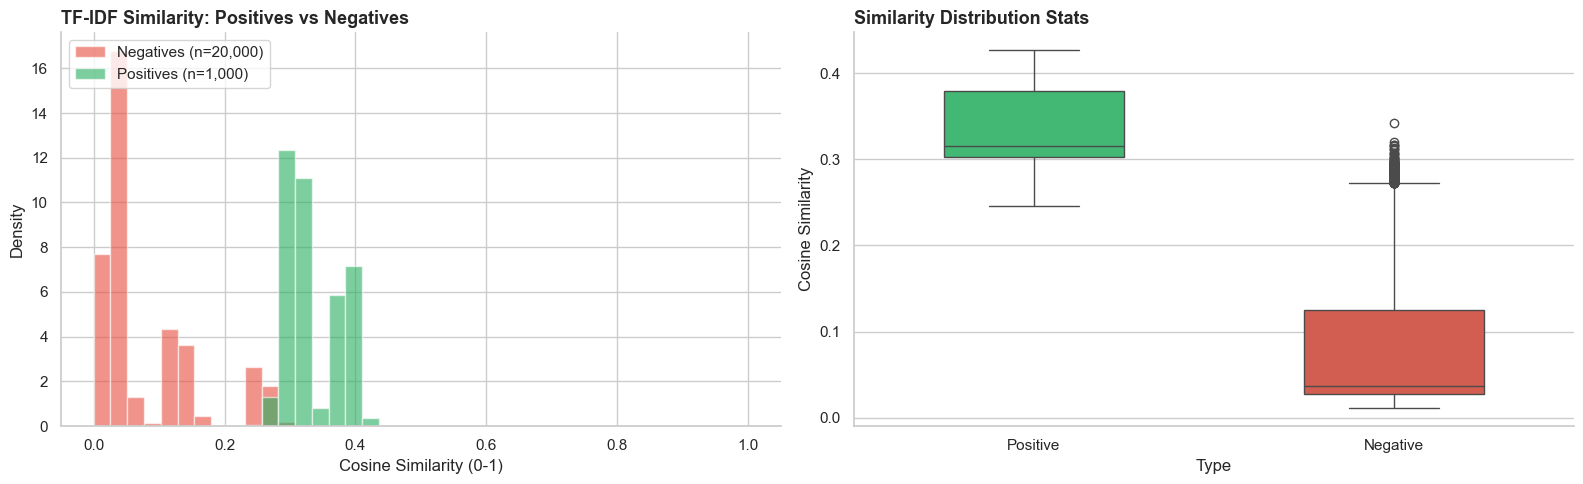

📊 STATS:
  • Positive Mean Sim: 0.334 ± 0.041
  • Negative Mean Sim: 0.080 ± 0.077
  • Separation Gap:    0.254

💡 INTERPRETATION:
  • Low Separation (<0.3): The Hard Negatives are textually very similar to the Query.
    The Neural Network (NN) is essential here to use other features (Amounts, Dates, Patterns) to distinguish them.


In [66]:
# Visual: TF-IDF similarity distribution (positive vs negative pairs)
# Checks if simple TF-IDF is enough or if we need a Neural Net
pos_sims, neg_sims = [], []

n_episodes_plot= 1000

# Collect similarities from a sample of episodes
for ep in episodes_train[:n_episodes_plot]: 
    q_text = ep["query_row"].get("combined_text", "")
    cands = ep["candidates_df"]
    if cands is None or cands.empty or "combined_text" not in cands.columns:
        continue
    
    texts = [q_text] + cands["combined_text"].fillna("").tolist()
    vecs = vectorizer.transform(texts).toarray()
    
    # Calculate cosine sim between Query (idx 0) and all Candidates (idx 1..)
    sims = cosine_similarity(vecs[0:1], vecs[1:])[0]
    
    # Index 0 in candidates is always positive, rest are negatives
    pos_sims.append(sims[0])
    neg_sims.extend(sims[1:])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.set_theme(style="whitegrid")

# Left: Overlapping Histograms (Separation Check)
bins = np.linspace(0, 1, 40)
axes[0].hist(neg_sims, bins=bins, alpha=0.6, density=True, label=f"Negatives (n={len(neg_sims):,})", color="#e74c3c")
axes[0].hist(pos_sims, bins=bins, alpha=0.6, density=True, label=f"Positives (n={len(pos_sims):,})", color="#27ae60")
axes[0].set_title("TF-IDF Similarity: Positives vs Negatives", fontsize=13, fontweight='bold', loc='left')
axes[0].set_xlabel("Cosine Similarity (0-1)")
axes[0].set_ylabel("Density")
axes[0].legend(loc="upper left")
sns.despine(ax=axes[0])

# Right: Boxplot (Distribution Stats)
data_sim = []
data_sim.extend([{"Type": "Positive", "Similarity": x} for x in pos_sims])
data_sim.extend([{"Type": "Negative", "Similarity": x} for x in neg_sims])
df_sim = pd.DataFrame(data_sim)

sns.boxplot(data=df_sim, x="Type", y="Similarity", palette={"Positive": "#2ecc71", "Negative": "#e74c3c"}, ax=axes[1], width=0.5)
axes[1].set_title("Similarity Distribution Stats", fontsize=13, fontweight='bold', loc='left')
axes[1].set_ylabel("Cosine Similarity")
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

# Text Explanation
sep_gap = np.mean(pos_sims) - np.mean(neg_sims)
print(f"📊 STATS:")
print(f"  • Positive Mean Sim: {np.mean(pos_sims):.3f} ± {np.std(pos_sims):.3f}")
print(f"  • Negative Mean Sim: {np.mean(neg_sims):.3f} ± {np.std(neg_sims):.3f}")
print(f"  • Separation Gap:    {sep_gap:.3f}")

print("\n💡 INTERPRETATION:")
if sep_gap > 0.3:
    print("  • High Separation (>0.3): TF-IDF alone is quite strong. The model will converge quickly.")
else:
    print("  • Low Separation (<0.3): The Hard Negatives are textually very similar to the Query.")
    print("    The Neural Network (NN) is essential here to use other features (Amounts, Dates, Patterns) to distinguish them.")

## Step 7 — Model Initialisation (Dynamic Training)

Wrap episodes in **PyTorch datasets** and create **data loaders**. The Siamese network has:

| Component | Input → Output |
|-----------|---------------|
| **Text encoder** | TF-IDF vector `(T,)` → `(32,)` |
| **Scalar encoder** | `[log_amount, date_norm]` `(2,)` → `(8,)` |
| **Fusion layer** | `(32+8,)` → `(32,)` embedding |
| **Comparison head** | `[|u-v|, u⊙v, pair_feats]` `(32+32+3,)` → logit |

Both query and candidate go through the **same shared encoder** (weight sharing = Siamese architecture), then the comparison head scores each candidate.

### Dynamic Episode Rebuilding

Instead of training on a **static** set of episodes every epoch, we **rebuild training episodes with a new random seed each epoch**. This means:
- The **same query trades** are used, but **different negatives** are sampled each time
- The model sees **fresh hard-negative combinations** every epoch → better generalisation
- Val/Test episodes remain **fixed** for consistent evaluation

In [67]:
# Wrap episodes in PyTorch datasets and build DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_ds_kwargs = dict(vectorizer=vectorizer, amount_col=AMOUNT_COL, date_cols=DATE_COLS, ref_col=REF_COL)
train_ds = RankingEpisodeDataset(episodes_train, **_ds_kwargs)
val_ds   = RankingEpisodeDataset(episodes_val, **_ds_kwargs)
test_ds  = RankingEpisodeDataset(episodes_test, **_ds_kwargs)

print(f"Episodes: {len(train_ds)} train, {len(val_ds)} val, {len(test_ds)} test")

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_episodes_flat)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_episodes_flat)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_episodes_flat)

# Quick shape check
batch = next(iter(train_loader))
print(f"Batch shapes: t_as={batch['t_as'].shape}, pf={batch['pf'].shape}, lengths={batch['lengths'].shape}")

Episodes: 2056 train, 440 val, 442 test
Batch shapes: t_as=torch.Size([672, 48027]), pf=torch.Size([672, 3]), lengths=torch.Size([32])
Batch shapes: t_as=torch.Size([672, 48027]), pf=torch.Size([672, 3]), lengths=torch.Size([32])


In [68]:
# Initialise the Siamese network and optimiser
model = SiameseMatchingNet(
    text_input_dim=VOCAB_SIZE,
    scalar_input_dim=2,
    pair_feat_dim=3,
    embed_dim=32,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [69]:
# Inspect: Model architecture and parameter count
print("=== SiameseMatchingNet ===")
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Device:               {device}")

# Show layer shapes
print("\n=== Layer Shapes ===")
for name, param in model.named_parameters():
    print(f"  {name:30s}  {str(list(param.shape)):20s}  ({param.numel():,} params)")

=== SiameseMatchingNet ===
SiameseMatchingNet(
  (text_fc): Linear(in_features=48027, out_features=32, bias=True)
  (scalar_fc): Linear(in_features=2, out_features=8, bias=True)
  (encode_mix): Linear(in_features=40, out_features=32, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=67, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Total parameters:     1,539,337
Trainable parameters: 1,539,337
Device:               cpu

=== Layer Shapes ===
  text_fc.weight                  [32, 48027]           (1,536,864 params)
  text_fc.bias                    [32]                  (32 params)
  scalar_fc.weight                [8, 2]                (16 params)
  scalar_fc.bias                  [8]                   (8 params)
  encode_mix.weight               [32, 40]              (1,280 params)
  encode_mix.bias                 [32]                  (32 params)
  classifier.0.we

## Step 8 — Training Loop (Dynamic + Introspection)

Train with **listwise cross-entropy loss**: for each episode, softmax over all candidate logits and optimise so the positive's probability is maximised.

$$\mathcal{L} = -\log \frac{e^{s_+}}{\sum_{j=1}^{K} e^{s_j}}$$

where $s_+$ is the logit of the positive candidate and $K$ is the total number of candidates.

### What's different here:
1. **Dynamic episodes**: Training episodes are **rebuilt each epoch** with fresh negatives (different `random_state`), so the model never memorises a fixed set.
2. **Introspection artifacts**: We capture per-epoch snapshots of gradients, weights, score margins, per-rule accuracy, and embeddings. These are plotted in Step 10.
3. **Early stopping** monitors validation loss and restores the best model weights (patience = 5 epochs).

In [ ]:
# Force reload updated modules (if we edited siamese_network.py or augmentation.py)
import importlib
import src.model.nn_matching.models.siamese_network
import src.model.nn_matching.pipeline.augmentation
importlib.reload(src.model.nn_matching.pipeline.augmentation)
importlib.reload(src.model.nn_matching.models.siamese_network)
from src.model.nn_matching.models.siamese_network import (
    SiameseMatchingNet, RankingEpisodeDataset, collate_episodes_flat
)
print("✅ Modules reloaded")

In [70]:
# Training loop with dynamic episode rebuilding + introspection artifacts
import copy
import seaborn as sns

EPOCHS = 8
BATCH_SIZE = 32

train_losses, val_losses = [], []
val_precisions, val_recalls, val_mrrs = [], [], []

# ── Introspection storage ───────────────────────────────────────────
# These artifacts let us visualise HOW the NN learns
gradient_norms   = []          # Per-epoch avg gradient L2 norm
weight_snapshots = {}          # {layer_name: [epoch0_stats, epoch1_stats, ...]}
score_margins    = []          # Per-epoch avg (pos_score - max_neg_score)
per_rule_history = {}          # {rule: [p@1_epoch0, p@1_epoch1, ...]}
embedding_snapshots = []       # Per-epoch PCA of embeddings (sampled)

best_val_loss = float('inf')
patience = 5
no_improve_count = 0
best_model_state = None

# Pre-build val/test loaders (static, never change)
_ds_kwargs = dict(vectorizer=vectorizer, amount_col=AMOUNT_COL, date_cols=DATE_COLS, ref_col=REF_COL)
val_ds   = RankingEpisodeDataset(episodes_val, **_ds_kwargs)
test_ds  = RankingEpisodeDataset(episodes_test, **_ds_kwargs)
val_loader  = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_episodes_flat)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_episodes_flat)

print(f"🚀 Training for up to {EPOCHS} epochs (patience={patience})")
print(f"   Dynamic rebuild: ON (new negatives each epoch)")
print(f"   Data augmentation: {'ON' if AUGMENT_TRAIN else 'OFF'}")
if AUGMENT_TRAIN:
    enabled = [k.replace('enable_', '') for k, v in AUGMENT_PARAMS.items() if k.startswith('enable_') and v]
    print(f"   Active perturbations: {', '.join(enabled)}")
print(f"   Val episodes: {len(val_ds)} (static)  |  Test episodes: {len(test_ds)} (static)")
print(f"{'─'*70}")

for epoch in range(EPOCHS):
    # ── 1. DYNAMIC EPISODE REBUILD ──────────────────────────────────
    # Each epoch gets a different random_state → different negatives
    epoch_seed = 42 + epoch * 1000
    
    ep_train, _ = _builder(
        df_pool=df_pool_train, n_episodes=N_EPISODES_TRAIN,
        random_state=epoch_seed, **_episode_kwargs,
    )
    
    train_ds = RankingEpisodeDataset(
        ep_train, **_ds_kwargs,
        augment=AUGMENT_TRAIN,
        augment_params=AUGMENT_PARAMS,
        columns_to_normalize=columns_to_normalize_reduced,
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_episodes_flat)
    
    # ── 2. TRAIN ────────────────────────────────────────────────────
    model.train()
    running_loss = 0.0
    epoch_margins = []
    
    for batch in train_loader:
        t_as = batch["t_as"].to(device)
        s_as = batch["s_as"].to(device)
        t_bs = batch["t_bs"].to(device)
        s_bs = batch["s_bs"].to(device)
        pf   = batch["pf"].to(device)
        lengths = batch["lengths"].to(device)
        pos_ixs = batch["pos_ixs"].to(device)

        optimizer.zero_grad()
        logits = model(t_as, s_as, t_bs, s_bs, pf).squeeze(-1)
        loss = listwise_ce_from_groups(logits, lengths, pos_ixs)
        loss.backward()
        
        # ── Capture gradient norms BEFORE optimizer.step() ──────────
        # (This tells us how strongly the loss is pushing each layer)
        
        optimizer.step()
        running_loss += loss.item()
        
        # ── Capture score margins ───────────────────────────────────
        with torch.no_grad():
            start = 0
            for i in range(lengths.numel()):
                K = int(lengths[i].item())
                z = logits[start:start+K]
                pos_score = z[pos_ixs[i]].item()
                neg_mask = torch.ones(K, dtype=torch.bool)
                neg_mask[pos_ixs[i]] = False
                if neg_mask.any():
                    max_neg = z[neg_mask].max().item()
                    epoch_margins.append(pos_score - max_neg)
                start += K

    avg_train = running_loss / max(1, len(train_loader))
    train_losses.append(avg_train)
    score_margins.append(np.mean(epoch_margins) if epoch_margins else 0.0)
    
    # ── Capture gradient norms (end of epoch) ───────────────────────
    total_grad_norm = 0.0
    n_params = 0
    for p in model.parameters():
        if p.grad is not None:
            total_grad_norm += p.grad.data.norm(2).item() ** 2
            n_params += 1
    gradient_norms.append(np.sqrt(total_grad_norm))
    
    # ── Capture weight statistics ───────────────────────────────────
    for name, param in model.named_parameters():
        if name not in weight_snapshots:
            weight_snapshots[name] = {"mean": [], "std": [], "min": [], "max": []}
        w = param.detach().cpu().numpy().flatten()
        weight_snapshots[name]["mean"].append(float(np.mean(w)))
        weight_snapshots[name]["std"].append(float(np.std(w)))
        weight_snapshots[name]["min"].append(float(np.min(w)))
        weight_snapshots[name]["max"].append(float(np.max(w)))

    # ── 3. VALIDATE ─────────────────────────────────────────────────
    model.eval()
    vloss = 0.0
    total_hits, total_eps, total_mrr = 0.0, 0.0, 0.0
    rule_hits = {}  # {rule: [hit_count, total_count]}

    with torch.no_grad():
        for batch in val_loader:
            t_as = batch["t_as"].to(device)
            s_as = batch["s_as"].to(device)
            t_bs = batch["t_bs"].to(device)
            s_bs = batch["s_bs"].to(device)
            pf   = batch["pf"].to(device)
            lengths = batch["lengths"].to(device)
            pos_ixs = batch["pos_ixs"].to(device)

            logits = model(t_as, s_as, t_bs, s_bs, pf).squeeze(-1)
            loss = listwise_ce_from_groups(logits, lengths, pos_ixs)
            vloss += loss.item()

            hits, eps, mrr = batch_metrics_from_logits(logits, lengths, pos_ixs)
            total_hits += hits
            total_eps  += eps
            total_mrr  += mrr
    
    # ── Per-rule P@1 on validation ──────────────────────────────────
    with torch.no_grad():
        for ep in episodes_val:
            q = ep["query_row"]
            c = ep["candidates_df"]
            rule = ep.get("rule", "UNKNOWN")
            
            vec_q, scal_q, vec_C, scal_C, pair_C, pos_ix = vectorize_episode(
                q, c, vectorizer=vectorizer, amount_col=AMOUNT_COL,
                date_cols=DATE_COLS, ref_col=REF_COL,
            )
            K = vec_C.shape[0]
            if K == 0:
                continue
            
            t_a = torch.from_numpy(np.repeat(vec_q[None,:], K, axis=0)).to(device)
            s_a = torch.from_numpy(np.repeat(scal_q[None,:], K, axis=0)).to(device)
            t_b = torch.from_numpy(vec_C).to(device)
            s_b = torch.from_numpy(scal_C).to(device)
            pf_t = torch.from_numpy(pair_C).to(device)
            
            scores = model(t_a, s_a, t_b, s_b, pf_t).squeeze(-1).cpu().numpy()
            hit = int(np.argmax(scores) == 0)
            
            if rule not in rule_hits:
                rule_hits[rule] = [0, 0]
            rule_hits[rule][0] += hit
            rule_hits[rule][1] += 1
    
    for rule, (h, t) in rule_hits.items():
        if rule not in per_rule_history:
            per_rule_history[rule] = []
        per_rule_history[rule].append(h / max(1, t))

    avg_val = vloss / max(1, len(val_loader))
    val_losses.append(avg_val)

    p_at1 = (total_hits / total_eps) if total_eps else 0.0
    r_at1 = p_at1
    mrr = (total_mrr / total_eps) if total_eps else 0.0
    val_precisions.append(p_at1)
    val_recalls.append(r_at1)
    val_mrrs.append(mrr)

    # ── Capture embedding snapshot (sample 50 val episodes) ─────────
    if (epoch % 2 == 0) or (epoch == EPOCHS - 1):
        sample_embeds = []
        sample_labels = []
        with torch.no_grad():
            for ep in episodes_val[:50]:
                q = ep["query_row"]
                c = ep["candidates_df"]
                vec_q, scal_q, vec_C, scal_C, pair_C, _ = vectorize_episode(
                    q, c, vectorizer=vectorizer, amount_col=AMOUNT_COL,
                    date_cols=DATE_COLS, ref_col=REF_COL,
                )
                K = vec_C.shape[0]
                if K == 0:
                    continue
                t_q = torch.from_numpy(vec_q[None,:]).to(device)
                s_q = torch.from_numpy(scal_q[None,:]).to(device)
                u = model.forward_one(t_q, s_q).cpu().numpy()[0]
                sample_embeds.append(u)
                sample_labels.append("Query")
                
                t_c = torch.from_numpy(vec_C[:1]).to(device)
                s_c = torch.from_numpy(scal_C[:1]).to(device)
                v = model.forward_one(t_c, s_c).cpu().numpy()[0]
                sample_embeds.append(v)
                sample_labels.append("Positive")
                
                if K > 1:
                    t_n = torch.from_numpy(vec_C[1:2]).to(device)
                    s_n = torch.from_numpy(scal_C[1:2]).to(device)
                    n_emb = model.forward_one(t_n, s_n).cpu().numpy()[0]
                    sample_embeds.append(n_emb)
                    sample_labels.append("Negative")
        
        embedding_snapshots.append({
            "epoch": epoch + 1,
            "embeddings": np.array(sample_embeds),
            "labels": sample_labels,
        })

    # ── Print epoch summary ─────────────────────────────────────────
    margin_str = f"{score_margins[-1]:+.3f}" if score_margins else "N/A"
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"train_loss: {avg_train:.4f} | val_loss: {avg_val:.4f} | "
        f"P@1: {p_at1:.3f} | MRR: {mrr:.3f} | "
        f"margin: {margin_str} | ∇norm: {gradient_norms[-1]:.3f}"
    )
    
    # Early stopping check
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        no_improve_count = 0
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"  ✓ New best val loss: {best_val_loss:.4f}")
    else:
        no_improve_count += 1
        print(f"  ⚠ No improvement for {no_improve_count}/{patience} epoch(s)")
    
    if no_improve_count >= patience:
        print(f"\n🛑 Early stopping after {epoch+1} epochs")
        break

print(f"{'─'*70}")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Restored best model (val_loss={best_val_loss:.4f})")
print(f"📦 Artifacts captured: {len(train_losses)} epochs of gradients, weights, margins, embeddings")

🚀 Training for up to 8 epochs (patience=5)
   Dynamic rebuild: ON (new negatives each epoch)
   Data augmentation: ON
   Active perturbations: token_dropout, char_noise, field_omission, scalar_noise
   Val episodes: 440 (static)  |  Test episodes: 442 (static)
──────────────────────────────────────────────────────────────────────
Building 1000 episodes with 7 workers …
✅ Done: 1000 episodes, 0 errors, 48.3s
✅ Done: 1000 episodes, 0 errors, 48.3s


TypeError: RankingEpisodeDataset.__init__() got an unexpected keyword argument 'augment'

## Step 9 — Evaluation & Analysis

Evaluate the trained model on the held-out test set. Key metrics:

| Metric | What it measures |
|--------|-----------------|
| **P@1** (Precision at 1) | Fraction of episodes where the top-ranked candidate is correct |
| **MRR** (Mean Reciprocal Rank) | Average of 1/rank of the correct match. MRR=1.0 means always ranked 1st |
| **Loss** | Listwise cross-entropy on the test episodes |

In [71]:
# Evaluate on the held-out test set
model.eval()
test_loss = 0.0
test_hits, test_eps, test_mrr_sum = 0.0, 0.0, 0.0

with torch.no_grad():
    for batch in test_loader:
        t_as = batch["t_as"].to(device)
        s_as = batch["s_as"].to(device)
        t_bs = batch["t_bs"].to(device)
        s_bs = batch["s_bs"].to(device)
        pf   = batch["pf"].to(device)
        lengths = batch["lengths"].to(device)
        pos_ixs = batch["pos_ixs"].to(device)

        logits = model(t_as, s_as, t_bs, s_bs, pf).squeeze(-1)
        loss = listwise_ce_from_groups(logits, lengths, pos_ixs)
        test_loss += loss.item()

        hits, eps, mrr = batch_metrics_from_logits(logits, lengths, pos_ixs)
        test_hits   += hits
        test_eps    += eps
        test_mrr_sum += mrr

avg_test_loss = test_loss / max(1, len(test_loader))
test_p_at1 = (test_hits / test_eps) if test_eps else 0.0
test_mrr   = (test_mrr_sum / test_eps) if test_eps else 0.0

print(
    f"Test | loss: {avg_test_loss:.4f} | "
    f"P@1: {test_p_at1:.3f} | R@1: {test_p_at1:.3f} | MRR: {test_mrr:.3f}"
)

Test | loss: 3.2124 | P@1: 0.000 | R@1: 0.000 | MRR: 0.049


/var/folders/lm/mg395mvd36g3fsqg6gjxv4r40000gn/T/ipykernel_80829/1707231300.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 1].legend(fontsize=7, loc="lower right")


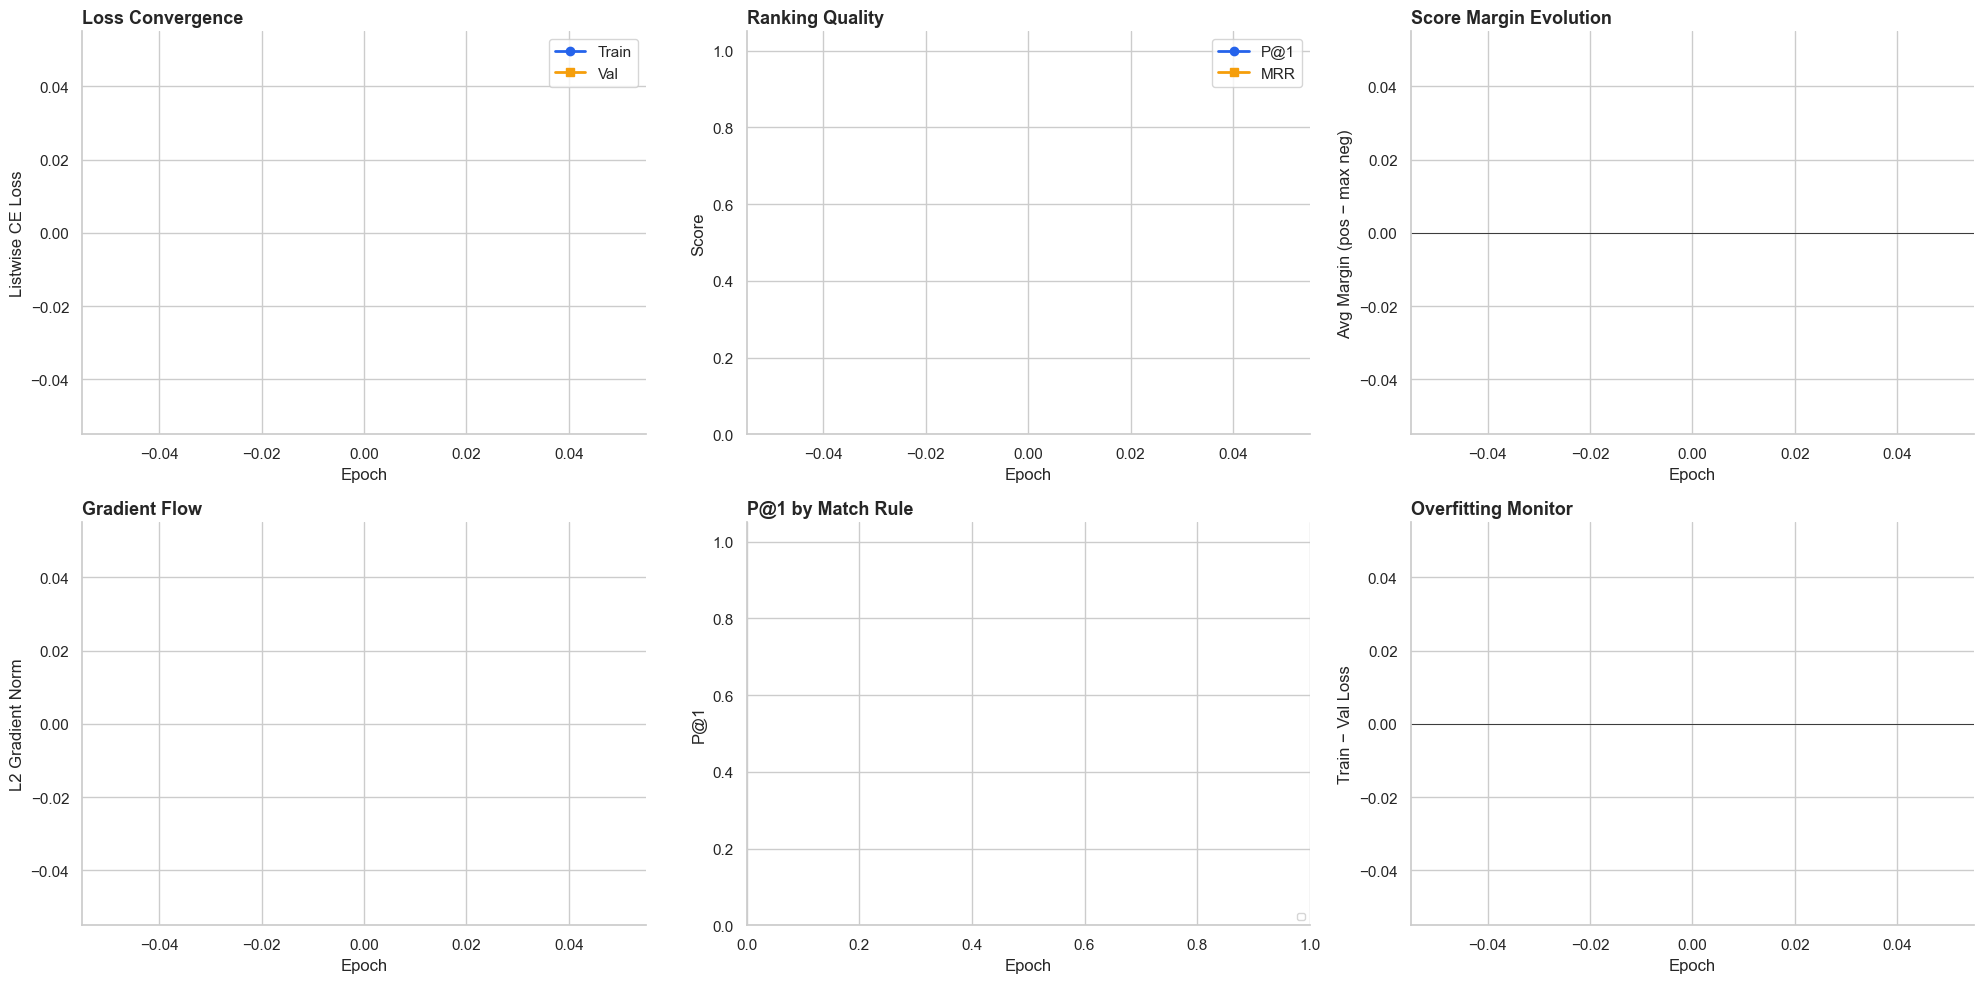


💡 HOW TO READ THESE CHARTS:
• Loss Convergence: Both curves should decrease. If train drops but val rises → overfitting.
• Ranking Quality: P@1 = 'did the model pick the right match first?'. MRR rewards partial correctness.
• Score Margin: Positive margin means the model scores the correct match HIGHER than all negatives.
  - Growing margin = increasing confidence. Negative margin = model is confused.
• Gradient Flow: Should start high (learning) and decrease (converging). Flat = saturated/stuck.
• P@1 by Rule: Shows which match types the model learns fastest. Lagging rules need more data.
• Overfitting Monitor: Green bars = healthy. Red bars = train loss << val loss (memorising).


In [72]:
# Visual: Training curves (6-panel with introspection)
import seaborn as sns
sns.set_theme(style="whitegrid", context="notebook")

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
epochs_range = range(1, len(train_losses) + 1)

# ── 1. Loss Curves ─────────────────────────────────────────────────
axes[0, 0].plot(epochs_range, train_losses, "o-", label="Train", color="#2563eb", lw=2)
axes[0, 0].plot(epochs_range, val_losses, "s-", label="Val", color="#f59e0b", lw=2)
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Listwise CE Loss")
axes[0, 0].set_title("Loss Convergence", fontsize=13, fontweight='bold', loc='left')
axes[0, 0].legend()
sns.despine(ax=axes[0, 0])

# ── 2. Validation Metrics ──────────────────────────────────────────
axes[0, 1].plot(epochs_range, val_precisions, "o-", label="P@1", color="#2563eb", lw=2)
axes[0, 1].plot(epochs_range, val_mrrs, "s-", label="MRR", color="#f59e0b", lw=2)
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_title("Ranking Quality", fontsize=13, fontweight='bold', loc='left')
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].legend()
sns.despine(ax=axes[0, 1])

# ── 3. Score Margin (Positive - Max Negative) ──────────────────────
# This is KEY: shows how confidently the model picks the right answer
colors_m = ["#ef4444" if m < 0 else "#22c55e" for m in score_margins]
axes[0, 2].bar(epochs_range, score_margins, color=colors_m, edgecolor="white", width=0.6)
axes[0, 2].axhline(0, color="black", lw=0.5)
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Avg Margin (pos − max neg)")
axes[0, 2].set_title("Score Margin Evolution", fontsize=13, fontweight='bold', loc='left')
sns.despine(ax=axes[0, 2])

# ── 4. Gradient Norms (Learning Signal Strength) ───────────────────
axes[1, 0].plot(epochs_range, gradient_norms, "o-", color="#8b5cf6", lw=2)
axes[1, 0].fill_between(epochs_range, 0, gradient_norms, alpha=0.15, color="#8b5cf6")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("L2 Gradient Norm")
axes[1, 0].set_title("Gradient Flow", fontsize=13, fontweight='bold', loc='left')
sns.despine(ax=axes[1, 0])

# ── 5. Per-Rule P@1 Evolution ──────────────────────────────────────
rule_colors = sns.color_palette("husl", len(per_rule_history))
for i, (rule, history) in enumerate(sorted(per_rule_history.items())):
    rule_epochs = range(1, len(history) + 1)
    axes[1, 1].plot(rule_epochs, history, "o-", label=rule[:25], color=rule_colors[i], lw=2, markersize=4)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("P@1")
axes[1, 1].set_title("P@1 by Match Rule", fontsize=13, fontweight='bold', loc='left')
axes[1, 1].set_ylim(0, 1.05)
axes[1, 1].legend(fontsize=7, loc="lower right")
sns.despine(ax=axes[1, 1])

# ── 6. Train vs Val Gap (Overfitting Indicator) ────────────────────
gap = [t - v for t, v in zip(train_losses, val_losses)]
colors_gap = ["#22c55e" if g <= 0 else "#ef4444" for g in gap]
axes[1, 2].bar(epochs_range, gap, color=colors_gap, edgecolor="white", width=0.6)
axes[1, 2].axhline(0, color="black", lw=0.5)
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel("Train − Val Loss")
axes[1, 2].set_title("Overfitting Monitor", fontsize=13, fontweight='bold', loc='left')
sns.despine(ax=axes[1, 2])

plt.tight_layout()
plt.show()

print("\n💡 HOW TO READ THESE CHARTS:")
print("• Loss Convergence: Both curves should decrease. If train drops but val rises → overfitting.")
print("• Ranking Quality: P@1 = 'did the model pick the right match first?'. MRR rewards partial correctness.")
print("• Score Margin: Positive margin means the model scores the correct match HIGHER than all negatives.")
print("  - Growing margin = increasing confidence. Negative margin = model is confused.")
print("• Gradient Flow: Should start high (learning) and decrease (converging). Flat = saturated/stuck.")
print("• P@1 by Rule: Shows which match types the model learns fastest. Lagging rules need more data.")
print("• Overfitting Monitor: Green bars = healthy. Red bars = train loss << val loss (memorising).")

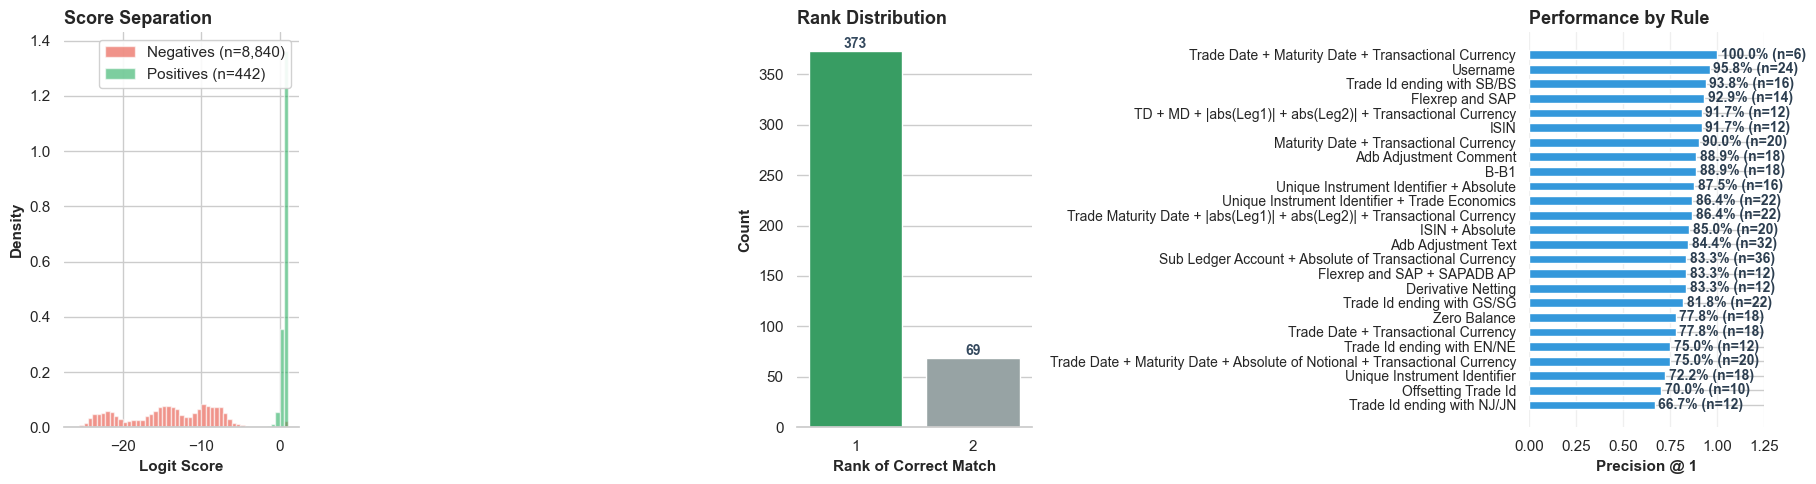


Test Rank Distribution:
  Rank 1: 373 episodes (84.4%)
  Rank 2: 69 episodes (15.6%)


In [49]:
# Visual: Score distribution and rank analysis on test set
import seaborn as sns
model.eval()
all_pos_scores, all_neg_scores = [], []
all_ranks = []
all_rules = []

with torch.no_grad():
    for ep in episodes_test:
        q = ep["query_row"]
        c = ep["candidates_df"]
        
        vec_q, scal_q, vec_C, scal_C, pair_C, pos_ix = vectorize_episode(
            q, c, vectorizer=vectorizer, amount_col=AMOUNT_COL,
            date_cols=DATE_COLS, ref_col=REF_COL,
        )
        
        K = vec_C.shape[0]
        t_a = torch.from_numpy(np.repeat(vec_q[None, :], K, axis=0)).to(device)
        s_a = torch.from_numpy(np.repeat(scal_q[None, :], K, axis=0)).to(device)
        t_b = torch.from_numpy(vec_C).to(device)
        s_b = torch.from_numpy(scal_C).to(device)
        pf = torch.from_numpy(pair_C).to(device)
        
        logits = model(t_a, s_a, t_b, s_b, pf).squeeze(-1)
        scores = logits.cpu().numpy()
        
        all_pos_scores.append(scores[0])
        all_neg_scores.extend(scores[1:].tolist())
        
        rank = int((np.argsort(-scores) == 0).argmax())
        all_ranks.append(rank + 1)  # 1-indexed
        all_rules.append(ep.get("rule", "UNKNOWN"))

# --- Professional Plotting ---
sns.set_theme(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
palette = sns.color_palette("muted")

# Left: Score Distribution (KDE + Hist)
# Note: we use common bins for cleaner overlay
bins = np.linspace(min(min(all_neg_scores), min(all_pos_scores)), 
                   max(max(all_neg_scores), max(all_pos_scores)), 50)

axes[0].hist(all_neg_scores, bins=bins, density=True, alpha=0.6, 
             label=f"Negatives (n={len(all_neg_scores):,})", color="#e74c3c")
axes[0].hist(all_pos_scores, bins=bins, density=True, alpha=0.6, 
             label=f"Positives (n={len(all_pos_scores):,})", color="#27ae60")

# Determine max density for text placement
axes[0].set_xlabel("Logit Score", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Density", fontsize=11, fontweight='bold')
axes[0].set_title("Score Separation", fontsize=13, fontweight='bold', loc='left')
axes[0].legend(frameon=True, framealpha=0.9, facecolor='white', loc='upper right')
sns.despine(ax=axes[0], left=True)

# Middle: Rank Distribution
rank_counts = pd.Series(all_ranks).value_counts().sort_index()
# Highlight Rank 1
colors = ["#27ae60" if r == 1 else "#95a5a6" for r in rank_counts.index]

bp = sns.barplot(x=rank_counts.index, y=rank_counts.values, hue=rank_counts.index, palette=colors, ax=axes[1], legend=False)
axes[1].set_xlabel("Rank of Correct Match", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Count", fontsize=11, fontweight='bold')
axes[1].set_title("Rank Distribution", fontsize=13, fontweight='bold', loc='left')

# Add counts on top
for p in bp.patches:
    if p.get_height() > 0:
        bp.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   fontsize=10, fontweight='bold', color="#34495e")
sns.despine(ax=axes[1], left=True)


# Right: P@1 per rule
rule_df = pd.DataFrame({"rule": all_rules, "rank": all_ranks})
rule_df["hit"] = (rule_df["rank"] == 1).astype(int)
per_rule = rule_df.groupby("rule").agg(
    p_at_1=("hit", "mean"),
    count=("hit", "count")
).sort_values("p_at_1", ascending=True)

y_pos = np.arange(len(per_rule))
axes[2].barh(y_pos, per_rule["p_at_1"], color="#3498db", height=0.6, edgecolor='white')
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels(per_rule.index, fontsize=10)
axes[2].set_xlabel("Precision @ 1", fontsize=11, fontweight='bold')
axes[2].set_title("Performance by Rule", fontsize=13, fontweight='bold', loc='left')
axes[2].set_xlim(0, 1.25) # Room for text
sns.despine(ax=axes[2], bottom=True, left=True)
axes[2].grid(axis='x', alpha=0.3)

# Add text labels
for i, (p, n) in enumerate(zip(per_rule["p_at_1"], per_rule["count"])):
    text_label = f"{p:.1%} (n={n})"
    axes[2].text(p + 0.02, i, text_label, va="center", fontsize=10, fontweight='bold', color="#2c3e50")

plt.tight_layout()
plt.show()

print(f"\nTest Rank Distribution:")
for r in sorted(rank_counts.index):
    pct = 100 * rank_counts[r] / len(all_ranks)
    print(f"  Rank {r}: {rank_counts[r]} episodes ({pct:.1f}%)")

## Step 10 — NN Internals Deep Dive

These plots reveal **how the neural network actually works** internally. Understanding them helps you diagnose issues and build trust in the model's decisions.

| Plot | What it shows | Healthy pattern |
|------|--------------|-----------------|
| **Embedding PCA** | How Query/Positive/Negative embeddings cluster over training | Q & P should converge; N should separate |
| **Weight Distributions** | How each layer's weights evolve | Should spread out gradually, not collapse |
| **Layer Activation** | What each encoder layer produces | Varied activations (not all zeros or saturated) |
| **Feature Importance** | Which input features drive the final score | Spread across text + scalar + pair features |

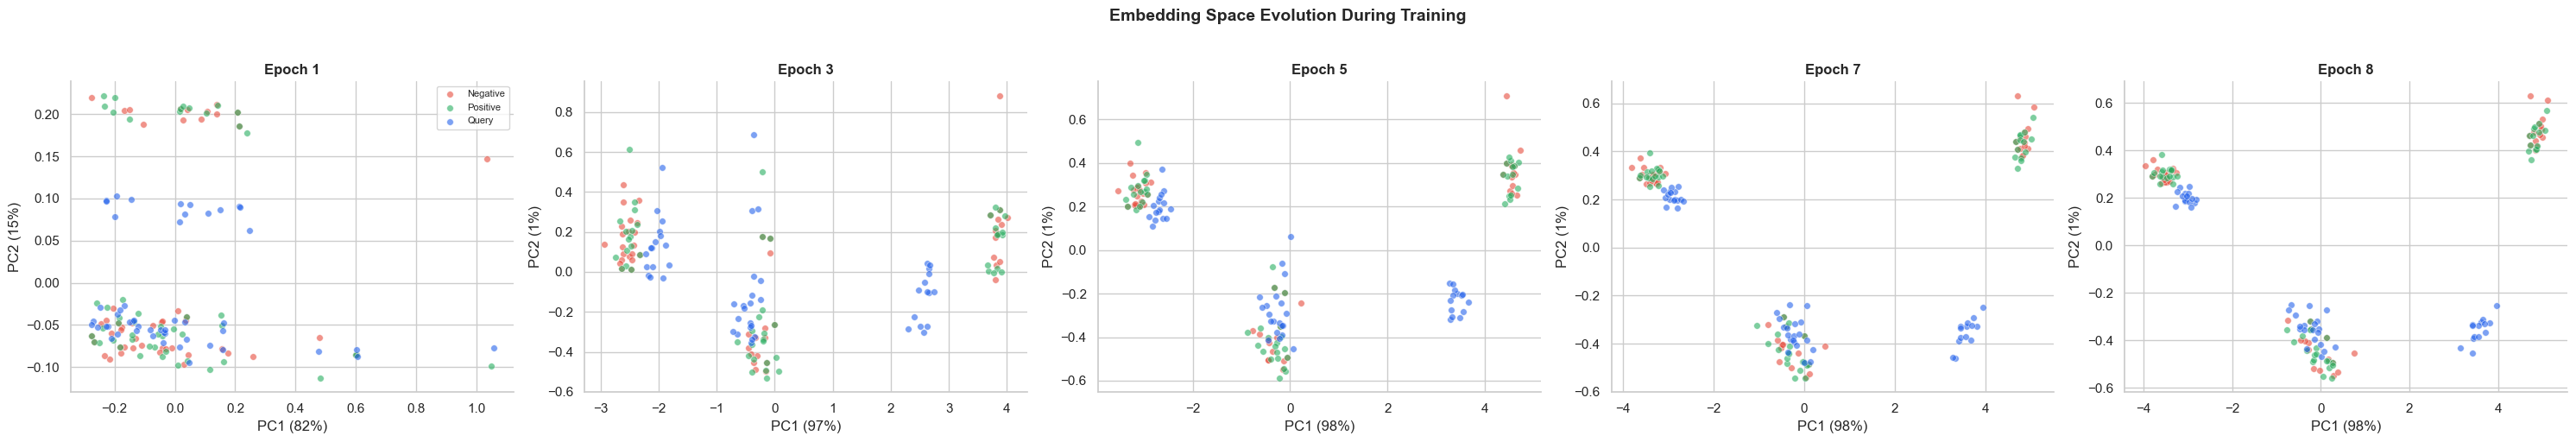


💡 HOW TO READ THIS:
• Each dot is a 32-d embedding projected onto 2D via PCA.
• Blue (Query) and Green (Positive) should CONVERGE over epochs — the model learns they are the same trade.
• Red (Negative) should SEPARATE from the Query/Positive cluster.
• If everything is clumped together → the model hasn't learned meaningful differences yet.


In [50]:
# ── 10a. Embedding Evolution: How the model learns to cluster matches ──
from sklearn.decomposition import PCA

if embedding_snapshots:
    n_snaps = len(embedding_snapshots)
    fig, axes = plt.subplots(1, n_snaps, figsize=(6 * n_snaps, 5))
    if n_snaps == 1:
        axes = [axes]
    
    palette = {"Query": "#2563eb", "Positive": "#27ae60", "Negative": "#e74c3c"}
    
    for idx, snap in enumerate(embedding_snapshots):
        embs = snap["embeddings"]
        labels = snap["labels"]
        ep_num = snap["epoch"]
        
        if len(embs) < 3:
            continue
        
        pca = PCA(n_components=2)
        coords = pca.fit_transform(embs)
        
        df_pca = pd.DataFrame({
            "PC1": coords[:, 0], "PC2": coords[:, 1], "Type": labels
        })
        
        for t in ["Negative", "Positive", "Query"]:
            subset = df_pca[df_pca["Type"] == t]
            axes[idx].scatter(subset["PC1"], subset["PC2"], c=palette[t], 
                            label=t, alpha=0.6, s=30, edgecolors="white", linewidth=0.5)
        
        axes[idx].set_title(f"Epoch {ep_num}", fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.0%})")
        axes[idx].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.0%})")
        if idx == 0:
            axes[idx].legend(loc="upper right", fontsize=8)
        sns.despine(ax=axes[idx])
    
    plt.suptitle("Embedding Space Evolution During Training", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 HOW TO READ THIS:")
    print("• Each dot is a 32-d embedding projected onto 2D via PCA.")
    print("• Blue (Query) and Green (Positive) should CONVERGE over epochs — the model learns they are the same trade.")
    print("• Red (Negative) should SEPARATE from the Query/Positive cluster.")
    print("• If everything is clumped together → the model hasn't learned meaningful differences yet.")
else:
    print("No embedding snapshots captured. Run the training loop first.")

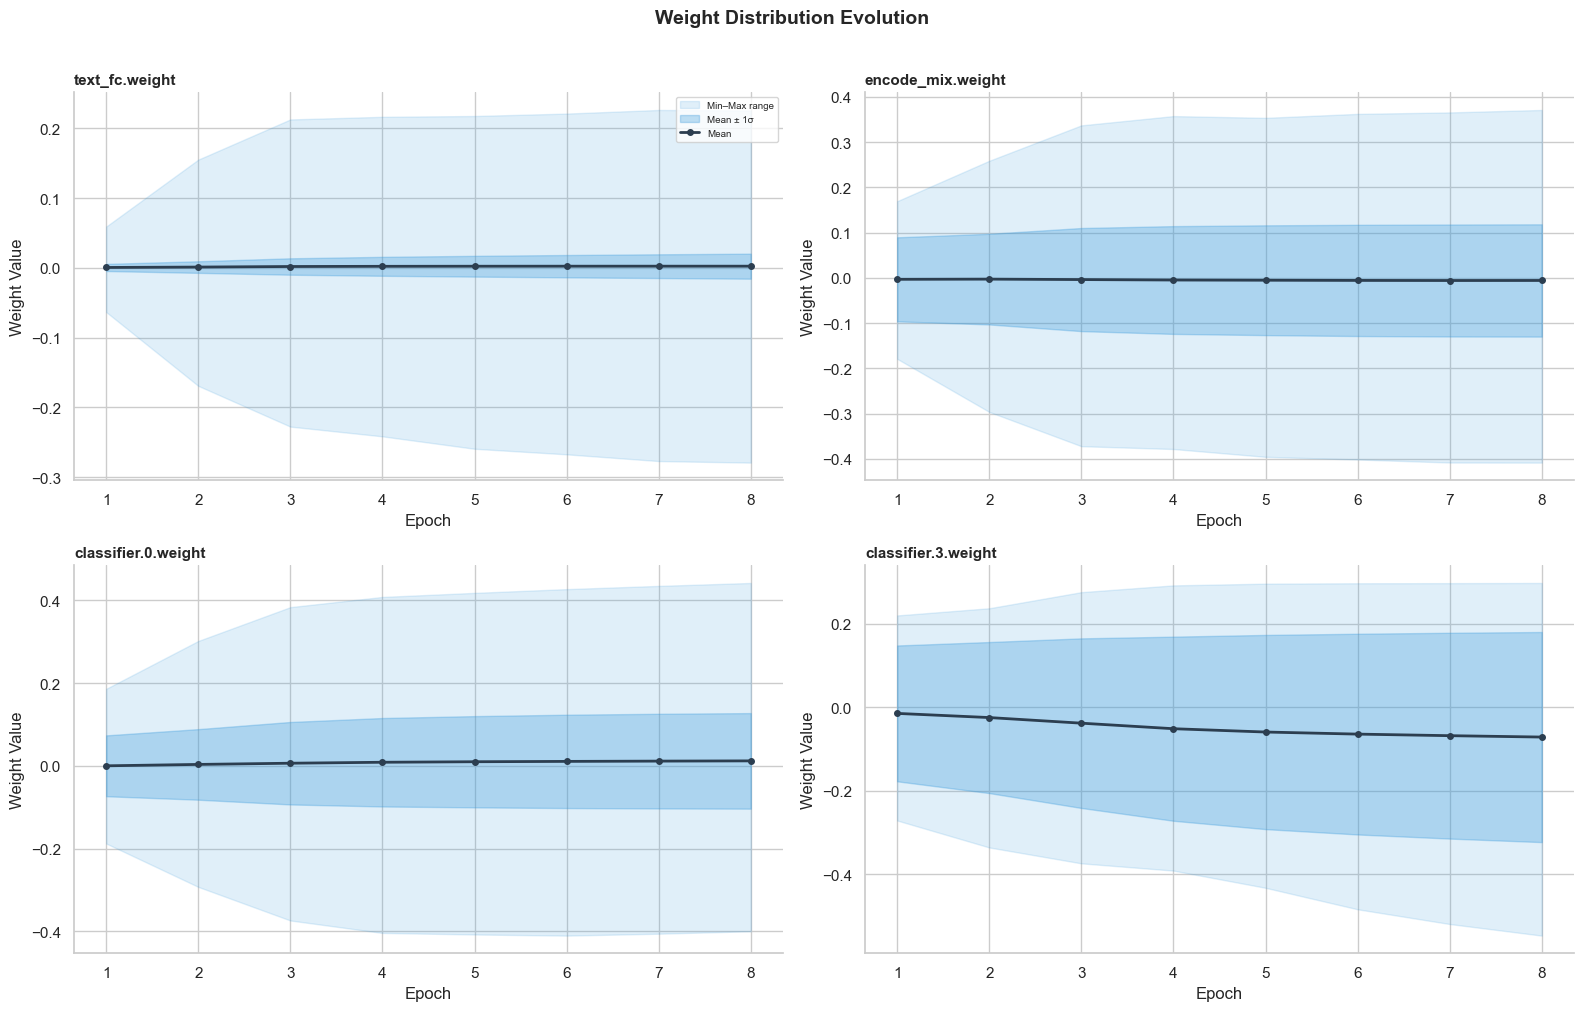


💡 HOW TO READ THIS:
• Each panel shows ONE layer's weight statistics over training epochs.
• text_fc.weight: The first layer that compresses TF-IDF (64k dims) → 32 dims.
  This layer learns WHICH character n-grams matter for matching.
• encode_mix.weight: Fuses text (32d) + scalars (8d) → final embedding (32d).
  This layer learns HOW to combine text similarity with amount/date signals.
• classifier.0.weight / classifier.3.weight: The comparison head.
  These learn WHAT patterns in |u-v| and u⊙v indicate a match.
• Healthy: Weights should spread out (σ increases) then stabilise.
• Unhealthy: Weights collapse to 0 (dying ReLU) or explode (divergence).


In [51]:
# ── 10b. Weight Distribution Evolution: How the NN parameters evolve ──
# Shows whether weights are healthy (spread) or sick (collapsed/exploded)

key_layers = ["text_fc.weight", "encode_mix.weight", "classifier.0.weight", "classifier.3.weight"]
available_layers = [k for k in key_layers if k in weight_snapshots]

if available_layers:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, layer_name in enumerate(available_layers[:4]):
        stats = weight_snapshots[layer_name]
        epochs_range_w = range(1, len(stats["mean"]) + 1)
        
        ax = axes[idx]
        ax.fill_between(epochs_range_w, stats["min"], stats["max"], alpha=0.15, color="#3498db", label="Min–Max range")
        ax.fill_between(epochs_range_w, 
                        [m - s for m, s in zip(stats["mean"], stats["std"])],
                        [m + s for m, s in zip(stats["mean"], stats["std"])],
                        alpha=0.3, color="#3498db", label="Mean ± 1σ")
        ax.plot(epochs_range_w, stats["mean"], "o-", color="#2c3e50", lw=2, markersize=4, label="Mean")
        
        ax.set_title(layer_name, fontsize=11, fontweight='bold', loc='left')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Weight Value")
        if idx == 0:
            ax.legend(fontsize=7, loc="upper right")
        sns.despine(ax=ax)
    
    # Hide unused axes
    for idx in range(len(available_layers), 4):
        axes[idx].axis("off")
    
    plt.suptitle("Weight Distribution Evolution", fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 HOW TO READ THIS:")
    print("• Each panel shows ONE layer's weight statistics over training epochs.")
    print("• text_fc.weight: The first layer that compresses TF-IDF (64k dims) → 32 dims.")
    print("  This layer learns WHICH character n-grams matter for matching.")
    print("• encode_mix.weight: Fuses text (32d) + scalars (8d) → final embedding (32d).")
    print("  This layer learns HOW to combine text similarity with amount/date signals.")
    print("• classifier.0.weight / classifier.3.weight: The comparison head.")
    print("  These learn WHAT patterns in |u-v| and u⊙v indicate a match.")
    print("• Healthy: Weights should spread out (σ increases) then stabilise.")
    print("• Unhealthy: Weights collapse to 0 (dying ReLU) or explode (divergence).")
else:
    print("No weight snapshots captured. Run the training loop first.")

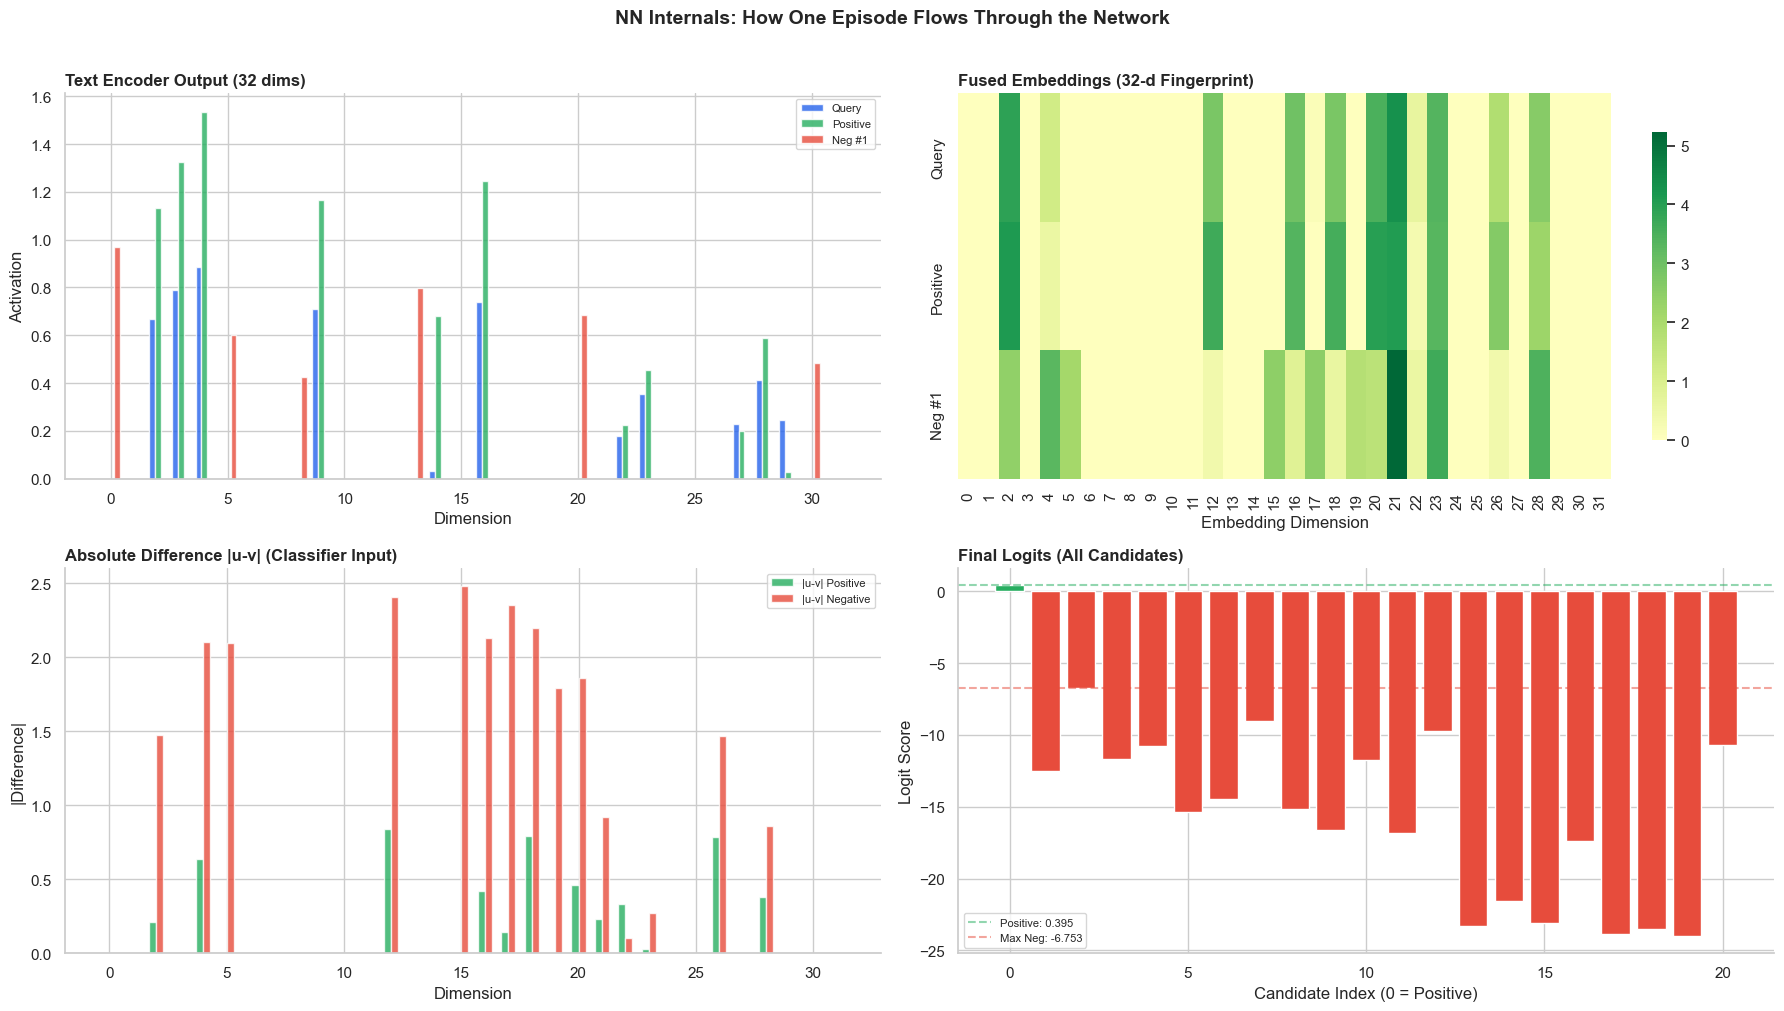


💡 HOW TO READ THIS:
• Text Encoder: Shows the 32-d compressed representation of each trade's TF-IDF text.
  Query and Positive should have SIMILAR activation patterns (same trade, different IDs).
• Fused Embeddings: The final 32-d 'identity vector' for each trade after combining text + scalars.
  Similar rows in the heatmap = similar trades.
• |u-v| (Absolute Difference): This is what the classifier looks at to decide 'match or not'.
  For the POSITIVE pair, |u-v| should be SMALL (near zero). For NEGATIVES, it should be LARGE.
• Final Logits: The model's confidence score for each candidate.
  The Positive (index 0, green) should have the HIGHEST logit → model ranks it first.


In [52]:
# ── 10c. Layer Activations: What does each layer produce for a real example? ──
# Feed ONE episode through the network and inspect activations at each stage

model.eval()
sample_ep = episodes_test[0]
q = sample_ep["query_row"]
c = sample_ep["candidates_df"]

vec_q, scal_q, vec_C, scal_C, pair_C, pos_ix = vectorize_episode(
    q, c, vectorizer=vectorizer, amount_col=AMOUNT_COL,
    date_cols=DATE_COLS, ref_col=REF_COL,
)

K = vec_C.shape[0]
t_a = torch.from_numpy(np.repeat(vec_q[None,:], K, axis=0)).to(device)
s_a = torch.from_numpy(np.repeat(scal_q[None,:], K, axis=0)).to(device)
t_b = torch.from_numpy(vec_C).to(device)
s_b = torch.from_numpy(scal_C).to(device)
pf_t = torch.from_numpy(pair_C).to(device)

with torch.no_grad():
    # ── Stage 1: Text encoder output ──
    text_out_q = torch.relu(model.text_fc(t_a))      # (K, 32)
    text_out_c = torch.relu(model.text_fc(t_b))      # (K, 32)
    
    # ── Stage 2: Scalar encoder output ──
    scalar_out_q = torch.relu(model.scalar_fc(s_a))   # (K, 8)
    scalar_out_c = torch.relu(model.scalar_fc(s_b))   # (K, 8)
    
    # ── Stage 3: Fused embedding ──
    u = model.forward_one(t_a, s_a)                    # (K, 32)
    v = model.forward_one(t_b, s_b)                    # (K, 32)
    
    # ── Stage 4: Comparison features ──
    diff_abs = torch.abs(u - v)                         # (K, 32)
    prod = u * v                                        # (K, 32)
    comparison_input = torch.cat([diff_abs, prod, pf_t], dim=1)  # (K, 67)
    
    # ── Stage 5: Final logits ──
    logits = model(t_a, s_a, t_b, s_b, pf_t).squeeze(-1)

# Convert to numpy
activations = {
    "Text Encoder (Query)": text_out_q[0].cpu().numpy(),
    "Text Encoder (Pos)": text_out_c[0].cpu().numpy(),
    "Text Encoder (Neg)": text_out_c[1].cpu().numpy() if K > 1 else text_out_c[0].cpu().numpy(),
    "Scalar Encoder (Query)": scalar_out_q[0].cpu().numpy(),
    "Fused Embedding (Query)": u[0].cpu().numpy(),
    "Fused Embedding (Pos)": v[0].cpu().numpy(),
    "|u-v| (Pos)": diff_abs[0].cpu().numpy(),
    "|u-v| (Neg)": diff_abs[1].cpu().numpy() if K > 1 else diff_abs[0].cpu().numpy(),
    "u⊙v (Pos)": prod[0].cpu().numpy(),
    "u⊙v (Neg)": prod[1].cpu().numpy() if K > 1 else prod[0].cpu().numpy(),
}

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Panel 1: Text encoder output (Query vs Positive vs Negative)
ax = axes[0, 0]
x_dims = np.arange(32)
ax.bar(x_dims - 0.25, activations["Text Encoder (Query)"], width=0.25, label="Query", color="#2563eb", alpha=0.8)
ax.bar(x_dims, activations["Text Encoder (Pos)"], width=0.25, label="Positive", color="#27ae60", alpha=0.8)
ax.bar(x_dims + 0.25, activations["Text Encoder (Neg)"], width=0.25, label="Neg #1", color="#e74c3c", alpha=0.8)
ax.set_title("Text Encoder Output (32 dims)", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("Dimension")
ax.set_ylabel("Activation")
ax.legend(fontsize=8)
sns.despine(ax=ax)

# Panel 2: Fused Embedding comparison (Heatmap)
ax = axes[0, 1]
embed_matrix = np.vstack([
    activations["Fused Embedding (Query)"],
    activations["Fused Embedding (Pos)"],
])
if K > 1:
    embed_matrix = np.vstack([embed_matrix, v[1].cpu().numpy()])
    row_labels = ["Query", "Positive", "Neg #1"]
else:
    row_labels = ["Query", "Positive"]
    
sns.heatmap(embed_matrix, cmap="RdYlGn", center=0, ax=ax, 
            yticklabels=row_labels, cbar_kws={"shrink": 0.8})
ax.set_title("Fused Embeddings (32-d Fingerprint)", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("Embedding Dimension")

# Panel 3: |u-v| comparison (what the classifier sees)
ax = axes[1, 0]
x_dims = np.arange(32)
ax.bar(x_dims - 0.15, activations["|u-v| (Pos)"], width=0.3, label="|u-v| Positive", color="#27ae60", alpha=0.8)
ax.bar(x_dims + 0.15, activations["|u-v| (Neg)"], width=0.3, label="|u-v| Negative", color="#e74c3c", alpha=0.8)
ax.set_title("Absolute Difference |u-v| (Classifier Input)", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("Dimension")
ax.set_ylabel("|Difference|")
ax.legend(fontsize=8)
sns.despine(ax=ax)

# Panel 4: Final scores (logits) for all candidates
ax = axes[1, 1]
all_logits = logits.cpu().numpy()
colors_l = ["#27ae60"] + ["#e74c3c"] * (len(all_logits) - 1)
bars = ax.bar(range(len(all_logits)), all_logits, color=colors_l, edgecolor="white")
ax.set_title("Final Logits (All Candidates)", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("Candidate Index (0 = Positive)")
ax.set_ylabel("Logit Score")
ax.axhline(all_logits[0], ls="--", color="#27ae60", alpha=0.5, label=f"Positive: {all_logits[0]:.3f}")
if len(all_logits) > 1:
    ax.axhline(max(all_logits[1:]), ls="--", color="#e74c3c", alpha=0.5, label=f"Max Neg: {max(all_logits[1:]):.3f}")
ax.legend(fontsize=8)
sns.despine(ax=ax)

plt.suptitle("NN Internals: How One Episode Flows Through the Network", fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 HOW TO READ THIS:")
print("• Text Encoder: Shows the 32-d compressed representation of each trade's TF-IDF text.")
print("  Query and Positive should have SIMILAR activation patterns (same trade, different IDs).")
print("• Fused Embeddings: The final 32-d 'identity vector' for each trade after combining text + scalars.")
print("  Similar rows in the heatmap = similar trades.")
print("• |u-v| (Absolute Difference): This is what the classifier looks at to decide 'match or not'.")
print("  For the POSITIVE pair, |u-v| should be SMALL (near zero). For NEGATIVES, it should be LARGE.")
print("• Final Logits: The model's confidence score for each candidate.")
print("  The Positive (index 0, green) should have the HIGHEST logit → model ranks it first.")

/var/folders/lm/mg395mvd36g3fsqg6gjxv4r40000gn/T/ipykernel_80829/763138858.py:99: UserWarning: Glyph 8857 (\N{CIRCLED DOT OPERATOR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/adrianvargas/Documents/projects/siamese_neural_net/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8857 (\N{CIRCLED DOT OPERATOR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


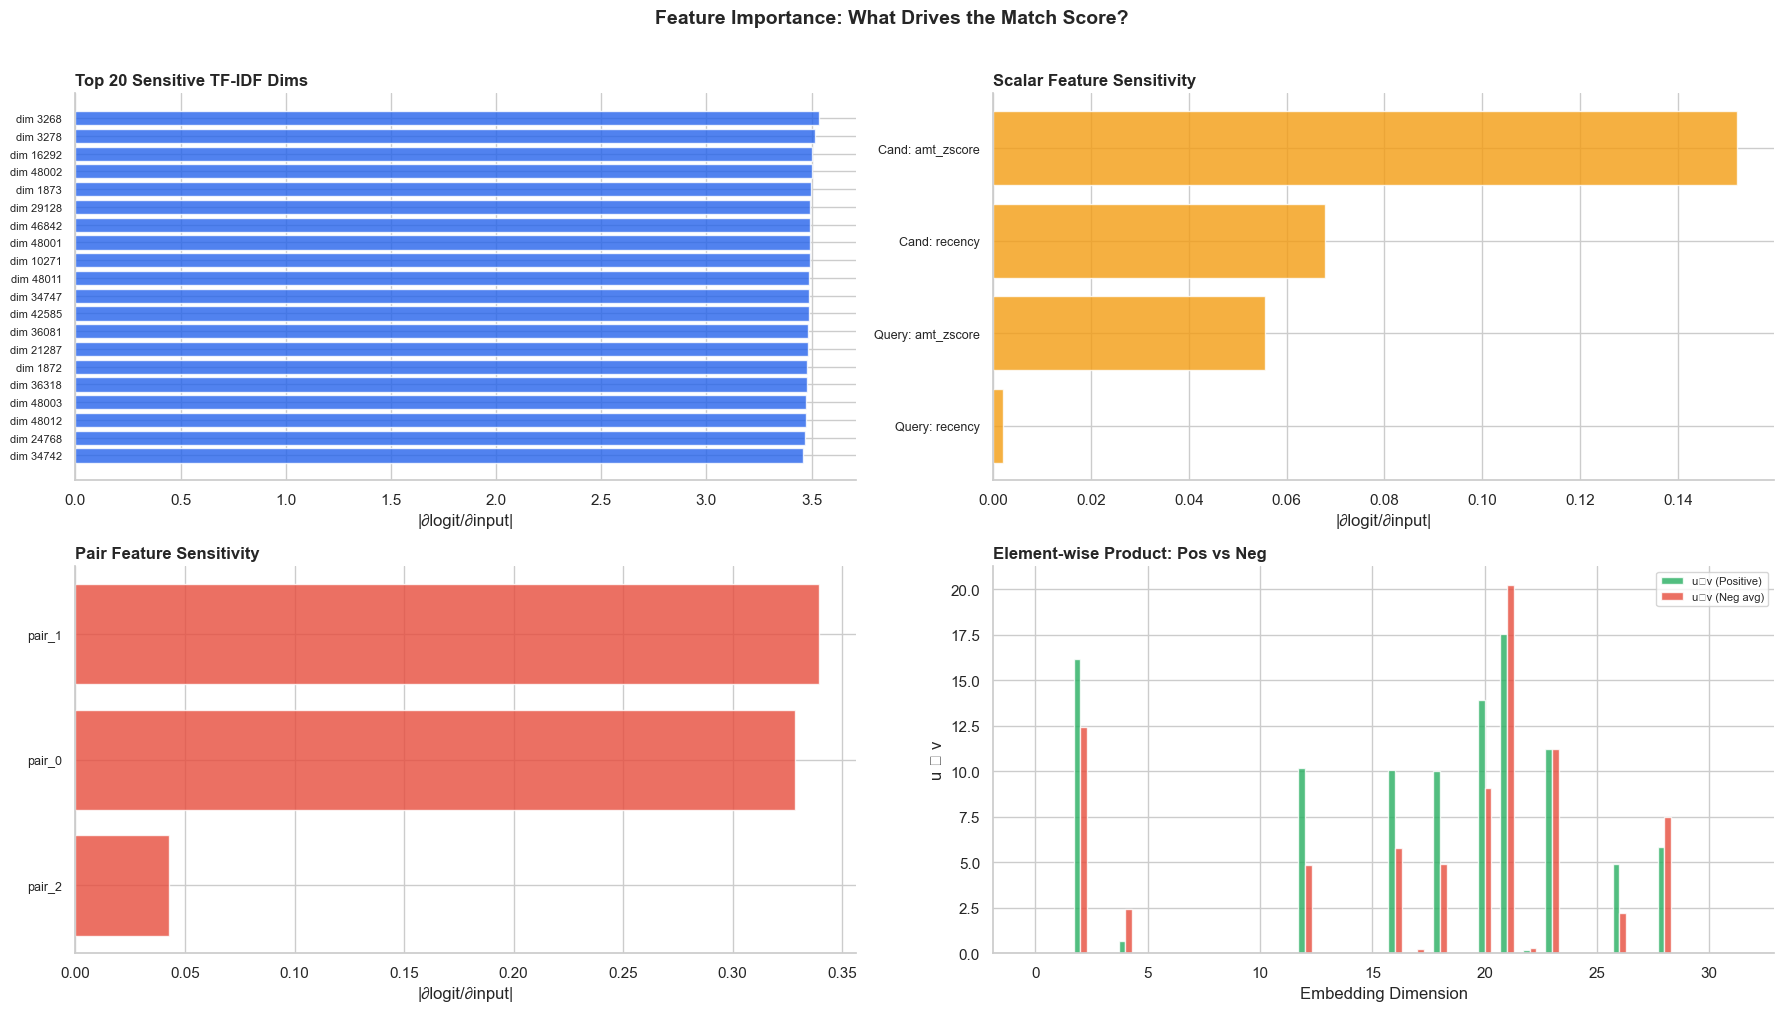


💡 FEATURE IMPORTANCE INTERPRETATION:
• TF-IDF Sensitivity: Shows which text dimensions the classifier relies on most.
  High-gradient dims correspond to n-grams that are discriminative for matching.
• Scalar Sensitivity: How much each numeric feature (amount z-score, recency) affects the score.
• Pair Feature Sensitivity: Direct comparison features (log-amount-diff, etc.) and their importance.
• u⊙v Product: The element-wise agreement between query and candidate embeddings.
  Positive matches should have HIGHER agreement (larger u⊙v values) than negatives.


In [53]:
# ── 10d. Feature Importance: Which dimensions drive the match decision? ──
# Gradient-based analysis: which embedding dimensions are the classifier most sensitive to?

model.eval()
sample_ep = episodes_test[0]
q = sample_ep["query_row"]
c = sample_ep["candidates_df"]

vec_q, scal_q, vec_C, scal_C, pair_C, pos_ix = vectorize_episode(
    q, c, vectorizer=vectorizer, amount_col=AMOUNT_COL,
    date_cols=DATE_COLS, ref_col=REF_COL,
)

K = vec_C.shape[0]
t_a = torch.from_numpy(np.repeat(vec_q[None,:], K, axis=0)).to(device).requires_grad_(True)
s_a = torch.from_numpy(np.repeat(scal_q[None,:], K, axis=0)).to(device).requires_grad_(True)
t_b = torch.from_numpy(vec_C).to(device).requires_grad_(True)
s_b = torch.from_numpy(scal_C).to(device).requires_grad_(True)
pf_t = torch.from_numpy(pair_C).to(device).requires_grad_(True)

# Compute gradients of the POSITIVE candidate's logit w.r.t. each input
logits = model(t_a, s_a, t_b, s_b, pf_t).squeeze(-1)
logit_pos = logits[0]  # positive candidate
logit_pos.backward()

# Capture input gradients (sensitivity)
text_grad_q = t_a.grad[0].abs().cpu().numpy()
text_grad_c = t_b.grad[0].abs().cpu().numpy()
scalar_grad_q = s_a.grad[0].abs().cpu().numpy()
scalar_grad_c = s_b.grad[0].abs().cpu().numpy()
pair_grad = pf_t.grad[0].abs().cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# ── Panel 1: Top-20 most sensitive TF-IDF dimensions ──
ax = axes[0, 0]
combined_text_grad = text_grad_q + text_grad_c
top_20_text = np.argsort(combined_text_grad)[-20:]
ax.barh(range(20), combined_text_grad[top_20_text], color="#2563eb", alpha=0.8)
ax.set_yticks(range(20))
ax.set_yticklabels([f"dim {i}" for i in top_20_text], fontsize=8)
ax.set_title("Top 20 Sensitive TF-IDF Dims", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("|∂logit/∂input|")
sns.despine(ax=ax)

# ── Panel 2: Scalar feature sensitivity ──
ax = axes[0, 1]
scalar_names_q = [f"Query: {n}" for n in (["amt_zscore", "recency"] if scal_q.shape[0] == 2 else [f"s{i}" for i in range(scal_q.shape[0])])]
scalar_names_c = [f"Cand: {n}" for n in (["amt_zscore", "recency"] if scal_q.shape[0] == 2 else [f"s{i}" for i in range(scal_q.shape[0])])]
all_scalar_names = scalar_names_q + scalar_names_c
all_scalar_grads = np.concatenate([scalar_grad_q, scalar_grad_c])
sorted_idx = np.argsort(all_scalar_grads)
ax.barh(range(len(all_scalar_names)), all_scalar_grads[sorted_idx], color="#f39c12", alpha=0.8)
ax.set_yticks(range(len(all_scalar_names)))
ax.set_yticklabels([all_scalar_names[i] for i in sorted_idx], fontsize=9)
ax.set_title("Scalar Feature Sensitivity", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("|∂logit/∂input|")
sns.despine(ax=ax)

# ── Panel 3: Pair feature sensitivity ──
ax = axes[1, 0]
pair_names = [f"pair_{i}" for i in range(pair_grad.shape[0])]
sorted_idx_p = np.argsort(pair_grad)
ax.barh(range(len(pair_names)), pair_grad[sorted_idx_p], color="#e74c3c", alpha=0.8)
ax.set_yticks(range(len(pair_names)))
ax.set_yticklabels([pair_names[i] for i in sorted_idx_p], fontsize=9)
ax.set_title("Pair Feature Sensitivity", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("|∂logit/∂input|")
sns.despine(ax=ax)

# ── Panel 4: Score breakdown — what makes pos stand out ──
ax = axes[1, 1]
with torch.no_grad():
    u = model.forward_one(t_a[:1], s_a[:1])
    all_v = model.forward_one(t_b, s_b)
    
    pos_diff = torch.abs(u - all_v[0:1]).squeeze().cpu().numpy()
    pos_prod = (u * all_v[0:1]).squeeze().cpu().numpy()
    
    if K > 1:
        neg_diffs = torch.abs(u - all_v[1:]).mean(dim=0).cpu().numpy()
        neg_prods = (u * all_v[1:]).mean(dim=0).cpu().numpy()
    else:
        neg_diffs = pos_diff * 0
        neg_prods = pos_prod * 0

# Show comparison: element-wise product for positive vs negative
x_d = np.arange(min(32, len(pos_prod)))
ax.bar(x_d - 0.15, pos_prod[:32], width=0.3, label="u⊙v (Positive)", color="#27ae60", alpha=0.8)
if K > 1:
    ax.bar(x_d + 0.15, neg_prods[:32], width=0.3, label="u⊙v (Neg avg)", color="#e74c3c", alpha=0.8)
ax.set_title("Element-wise Product: Pos vs Neg", fontsize=12, fontweight='bold', loc='left')
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("u ⊙ v")
ax.legend(fontsize=8)
sns.despine(ax=ax)

plt.suptitle("Feature Importance: What Drives the Match Score?", fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 FEATURE IMPORTANCE INTERPRETATION:")
print("• TF-IDF Sensitivity: Shows which text dimensions the classifier relies on most.")
print("  High-gradient dims correspond to n-grams that are discriminative for matching.")
print("• Scalar Sensitivity: How much each numeric feature (amount z-score, recency) affects the score.")
print("• Pair Feature Sensitivity: Direct comparison features (log-amount-diff, etc.) and their importance.")
print("• u⊙v Product: The element-wise agreement between query and candidate embeddings.")
print("  Positive matches should have HIGHER agreement (larger u⊙v values) than negatives.")